In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import polars as pl
import matplotlib.pyplot as plt
import glob
from scipy.signal import welch, butter, filtfilt
from scipy.signal import detrend
from scipy.signal import spectrogram, get_window
from scipy.stats import zscore
from scipy.integrate import simpson
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# Dataset with only Turn event
df_1 = pd.read_csv("/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/train/tdcsfog/04e10e0797.csv")

# Dataset with Turn and Walking event
df_2 = pd.read_csv("/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/train/tdcsfog/146bd622af.csv")

# Dataset with Turn and StartHesitation event
df_3 = pd.read_csv("/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/train/tdcsfog/166bc81085.csv")

In [3]:
print(df_1.head())
print(df_2.head())
print(df_3.head())

   Time      AccV     AccML     AccAP  StartHesitation  Turn  Walking
0     0 -9.330816  0.649608 -2.219920                0     0        0
1     1 -9.332794  0.631624 -2.195057                0     0        0
2     2 -9.330623  0.636067 -2.176996                0     0        0
3     3 -9.330805  0.647316 -2.179266                0     0        0
4     4 -9.331018  0.674393 -2.215282                0     0        0
   Time      AccV     AccML     AccAP  StartHesitation  Turn  Walking
0     0 -9.469575  0.803600 -1.414898                0     0        0
1     1 -9.467594  0.800920 -1.408512                0     0        0
2     2 -9.473403  0.799942 -1.407336                0     0        0
3     3 -9.467359  0.805807 -1.410385                0     0        0
4     4 -9.476454  0.810452 -1.410384                0     0        0
   Time      AccV     AccML     AccAP  StartHesitation  Turn  Walking
0     0 -9.477831 -1.041629 -1.081219                0     0        0
1     1 -9.470954 -1

In [4]:
def basic_stats(df):
    stats = {}
    for col in ["AccV", "AccML", "AccAP"]:
        stats[col] = {
            "mean": df[col].mean(),
            "std": df[col].std(),
            "min": df[col].min(),
            "max": df[col].max(),
            "median": df[col].median(),
            "q25": df[col].quantile(0.25),
            "q75": df[col].quantile(0.75),
        }
    return pd.DataFrame(stats)

In [5]:
overall_stats_1 = basic_stats(df_1)
print("Overall Stats in df_1:\n", overall_stats_1)

overall_stats_2 = basic_stats(df_2)
print("Overall Stats in df_2:\n", overall_stats_2)

overall_stats_3 = basic_stats(df_3)
print("Overall Stats in df_3:\n", overall_stats_3)

Overall Stats in df_1:
              AccV      AccML      AccAP
mean    -8.889149  -0.199604   3.695859
std      0.708428   0.919776   1.382500
min    -18.623516  -6.278487  -7.063795
max     -4.126374  10.029988  14.523853
median  -8.899208  -0.111615   3.810496
q25     -9.304930  -0.819081   3.563448
q75     -8.494233   0.483060   4.146544
Overall Stats in df_2:
              AccV     AccML      AccAP
mean    -9.559733  0.211931   1.042616
std      0.679613  0.794549   0.848803
min    -21.659887 -2.813945  -3.763821
max     -6.318983  4.734698  13.070144
median  -9.545045  0.207859   1.063720
q25     -9.702500 -0.192107   0.717624
q75     -9.358362  0.655242   1.420827
Overall Stats in df_3:
              AccV     AccML     AccAP
mean    -9.414298  0.362835  1.274337
std      0.903996  1.257047  1.843788
min    -15.684572 -6.376880 -4.105980
max     -5.667476  7.123671  5.651088
median  -9.440047  0.428729  1.617088
q25     -9.714201 -0.462071  0.484814
q75     -8.916375  1.052110  2

The function below generates line plots for each dataset, showing the accelerometer signals over time. If FoG events are present, they are highlighted as shaded rectangles in different colors, marking the exact time where the events occur.

In [6]:
def plot_fog_events_overlay(df, title):
    """
    Plot accelerometer signals with FoG events shaded directly on the same graph.
    """
    # Convert timestamps to seconds
    df["Time_sec"] = df["Time"] / 128.0  
    
    fig, ax = plt.subplots(figsize=(14, 6))
    
    # Plot all 3 accelerometer signals
    ax.plot(df["Time_sec"], df["AccV"], label="AccV (Vertical)", alpha=0.7)
    ax.plot(df["Time_sec"], df["AccML"], label="AccML (Medio-Lateral)", alpha=0.7)
    ax.plot(df["Time_sec"], df["AccAP"], label="AccAP (Antero-Posterior)", alpha=0.7)
    
    # Shade event regions
    colors = {
        "Turn": "green",
        "Walking": "blue",
        "StartHesitation": "red"
    }
    
    for event, color in colors.items():
        if event in df.columns:
            # Find contiguous segments where event == 1
            in_event = False
            start_time = None
            for t, val in zip(df["Time_sec"], df[event]):
                if val == 1 and not in_event:
                    in_event = True
                    start_time = t
                elif val == 0 and in_event:
                    in_event = False
                    ax.axvspan(start_time, t, color=color, alpha=0.2, label=event)
            # If event lasts until the end
            if in_event:
                ax.axvspan(start_time, df["Time_sec"].iloc[-1], color=color, alpha=0.2, label=event)
    
    ax.set_title(title)
    ax.set_xlabel("Time (seconds)")
    ax.set_ylabel("Acceleration (m/s^2)")
    ax.legend()
    plt.show()

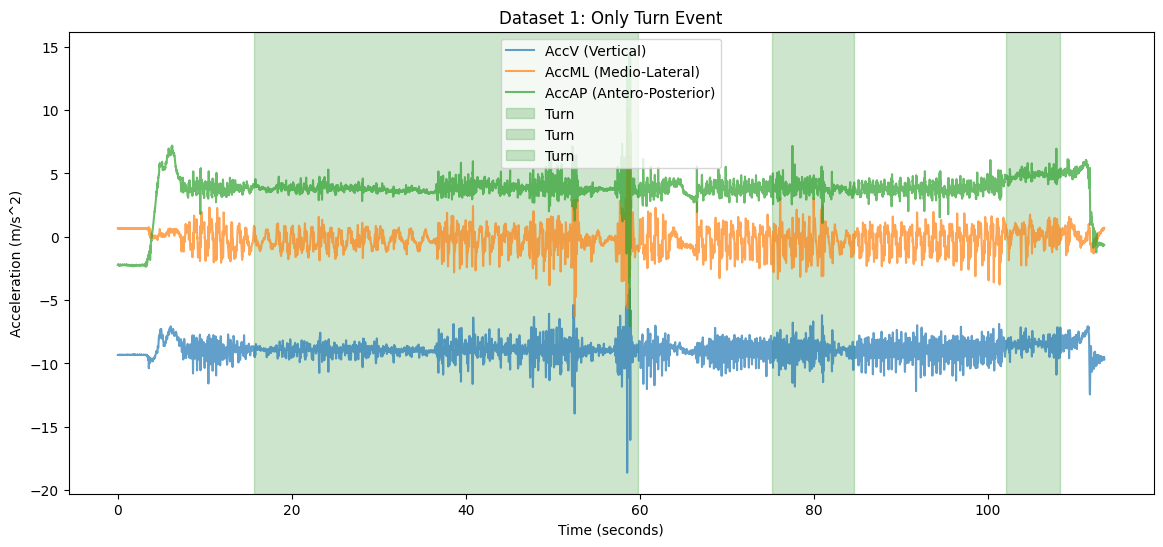

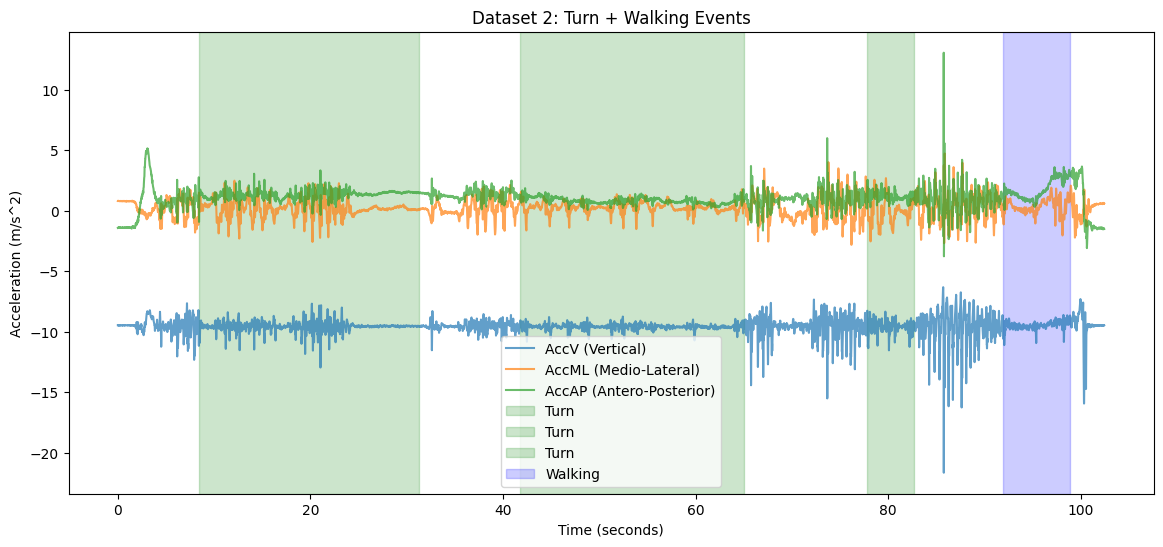

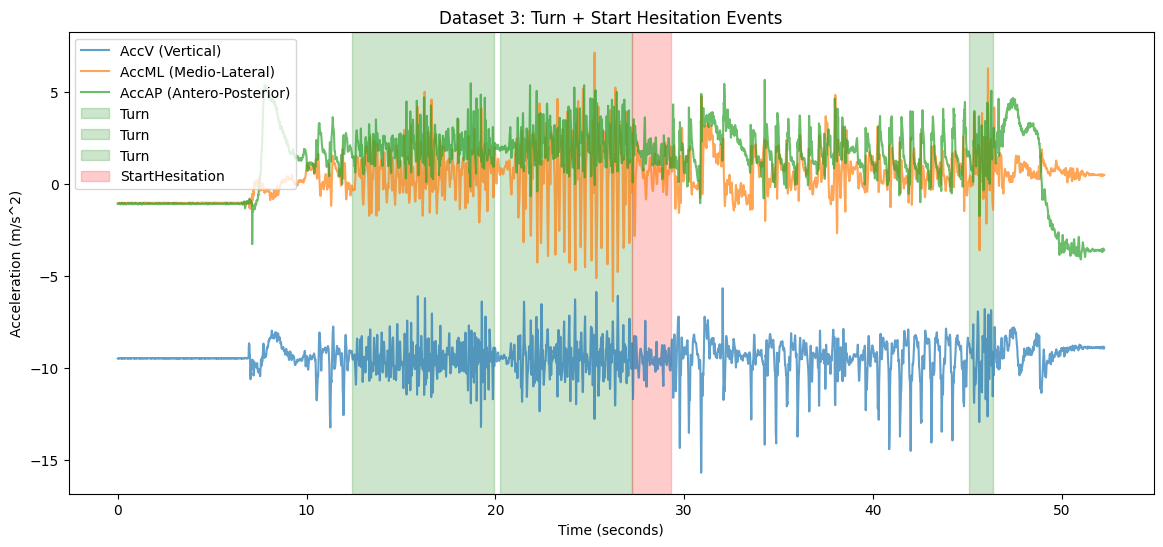

In [7]:
# Plotting all the datasets
plot_fog_events_overlay(df_1, "Dataset 1: Only Turn Event")
plot_fog_events_overlay(df_2, "Dataset 2: Turn + Walking Events")
plot_fog_events_overlay(df_3, "Dataset 3: Turn + Start Hesitation Events")

Dataset 1: Only Turn Event
In this first graph, the accelerometer data looks pretty stable overall, but once the FoG event starts, you can see the signals shift a bit, especially on the side-to-side axis. The shaded areas mark exactly when the event happens, and that’s when the data looks less smooth. It shows how the turn introduces some instability in the motion.

Dataset 2: Turn + Walking Events
In the second graph, the data has a steady rhythm that matches walking. What stands out is that during the FoG events, that rhythm breaks down. The signal doesn’t keep the same regular pattern anymore, and you can see sudden changes in the wave shapes. The shaded areas makes it clear where the events happen, and you can tell those moments line up with interruptions in the walking pattern.

Dataset 3: Turn + Start Hesitation Events
The third graph looks noisier than the others, but you can still spot the FoG events when you check the markers. At those points, the accelerations either slow down, bundle up, or don’t increase the way they normally should. That matches the hesitation before starting movement. Even with all the noise, the markers help show exactly when the hesitation happens.

In [8]:
def accel_magnitude(df):
    return np.sqrt(df['AccV']**2 + df['AccML']**2 + df['AccAP']**2)

In [9]:
# Function to plot magnitude with shaded event regions
def plot_magnitude_with_events(df, title):
    time = df["Time"].values / 128  # Convert to seconds
    magnitude = accel_magnitude(df)

    plt.figure(figsize=(12, 5))
    plt.plot(time, magnitude, label="Acceleration Magnitude", color="blue", alpha=0.7)

    # Shade event regions
    for event, color in zip(["StartHesitation", "Turn", "Walking"],
                            ["red", "green", "blue"]):
        if event in df.columns:
            in_event = False
            start_time = None
            for i, val in enumerate(df[event].values):
                if val == 1 and not in_event:
                    in_event = True
                    start_time = time[i]
                elif val == 0 and in_event:
                    in_event = False
                    plt.axvspan(start_time, time[i], color=color, alpha=0.3, label=event)
            # If event goes until the end of the recording
            if in_event:
                plt.axvspan(start_time, time[-1], color=color, alpha=0.3, label=event)

    # Make legend unique (avoid duplicates when multiple spans exist)
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())

    plt.xlabel("Time (seconds)")
    plt.ylabel("Magnitude")
    plt.title(title)
    plt.show()

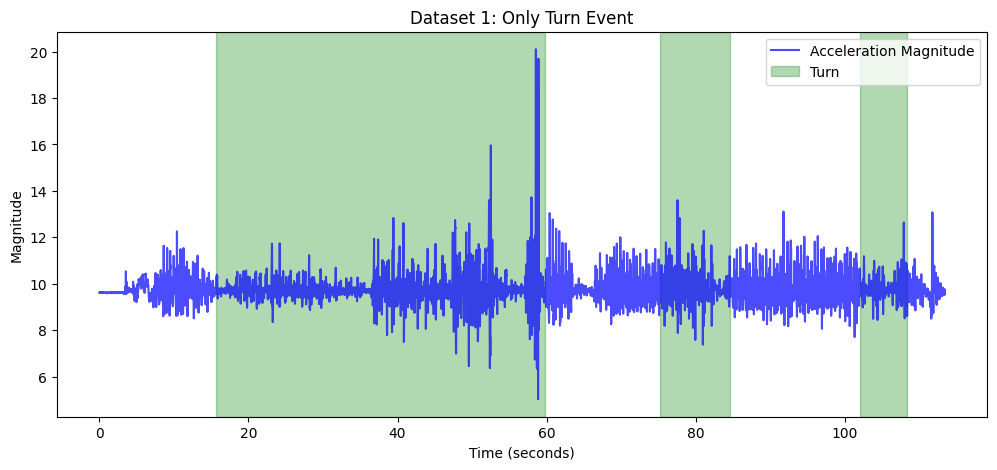

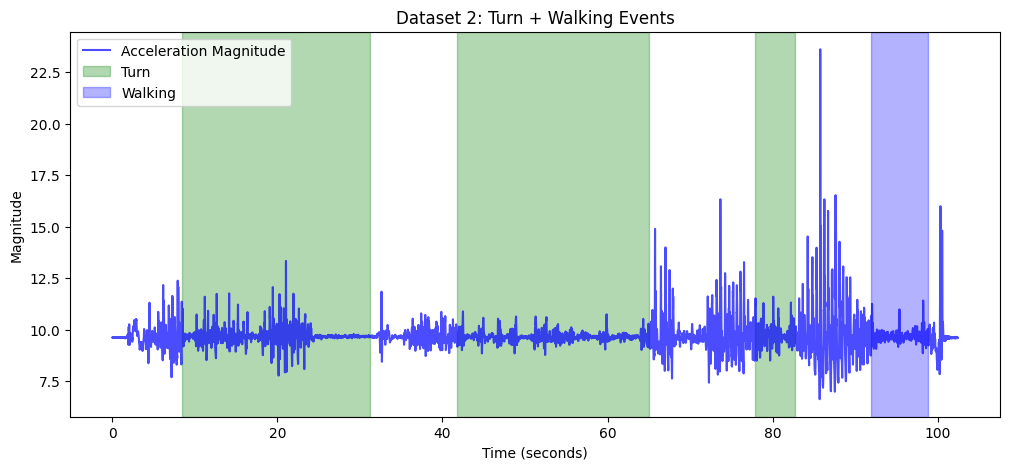

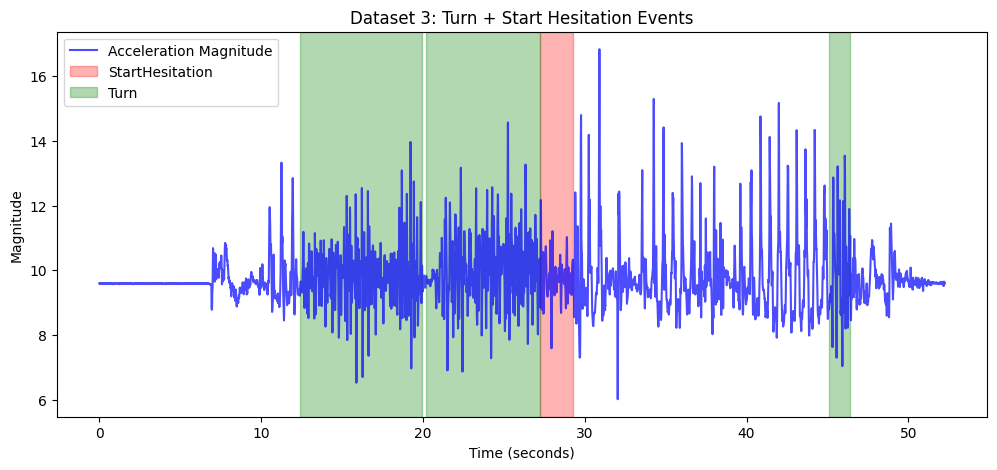

In [10]:
plot_magnitude_with_events(df_1, "Dataset 1: Only Turn Event")
plot_magnitude_with_events(df_2, "Dataset 2: Turn + Walking Events")
plot_magnitude_with_events(df_3, "Dataset 3: Turn + Start Hesitation Events")

In [11]:
def butter_lowpass_filter(signal, cutoff=15, fs=128, order=2):
    nyquist = 0.5 * fs
    norm_cutoff = cutoff / nyquist
    b, a = butter(order, norm_cutoff, btype='low', analog=False)
    filtered = filtfilt(b, a, signal)
    return filtered

In [12]:
def sliding_windows(n, win, hop):
    for start in range(0, n - win + 1, hop):
        yield start, start + win

In [13]:
def plot_individual_window_ffts(
    df, fs=128, window_sec=3.0, overlap=0.5,
    fog_fraction_threshold=0.5,
    freq_limit=15
):
    """
    Plots the FFT for each window using ONLY FoG event labels:
        - StartHesitation
        - Turn
        - Walking   (FoG walking)
        - NonFoG    (if no FoG event in window)
    """
    
    # 1. Combine and filter signal
    x = accel_magnitude(df)
    x = butter_lowpass_filter(x, cutoff=15, fs=fs)
    x = x - np.mean(x)

    # Extract FoG event columns
    fog_cols = [c for c in ['StartHesitation', 'Turn', 'Walking'] if c in df.columns]
    fog_matrix = df[fog_cols].to_numpy()

    # 2. Windowing
    win = int(window_sec * fs)
    hop = int(win * (1 - overlap))
    N = len(x)

    window_num = 1

    # 3. Loop through windows and plot
    for s, e in sliding_windows(N, win, hop):

        seg = x[s:e]

        # Mean occurrence of each FoG event type within the window
        window_events = fog_matrix[s:e].mean(axis=0)

        # Find dominant FoG event (if present)
        max_event_idx = np.argmax(window_events)
        max_event_value = window_events[max_event_idx]

        if max_event_value >= fog_fraction_threshold:
            label = fog_cols[max_event_idx]  # exact event name
        else:
            label = "NonFoG"

        # FFT computation
        seg = seg - np.mean(seg)
        fft_vals = np.fft.rfft(seg)
        freqs = np.fft.rfftfreq(len(seg), d=1/fs)
        mag = np.abs(fft_vals) / len(seg)

        # Limit to desired frequency range
        m = freqs <= freq_limit
        freqs = freqs[m]
        mag = mag[m]

        # Plot
        plt.figure(figsize=(8, 4))
        plt.plot(freqs, mag, linewidth=2)
        plt.title(
            f"Window {window_num} ({s/fs:.1f}s–{e/fs:.1f}s) — {label}"
        )
        plt.xlabel("Frequency (Hz)")
        plt.ylabel("Amplitude")
        plt.grid(True, alpha=0.3)
        plt.ylim(0, 0.40)
        plt.show()

        window_num += 1

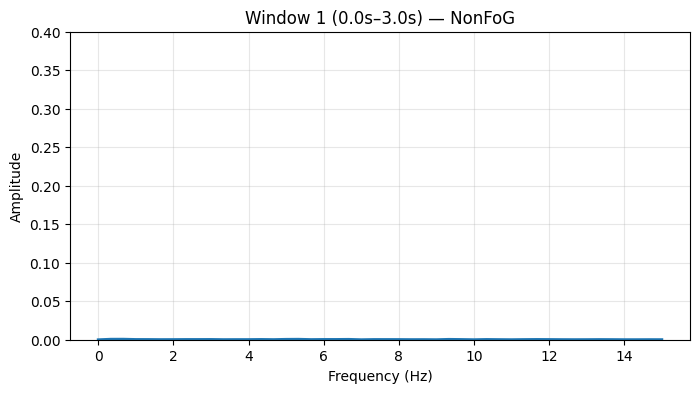

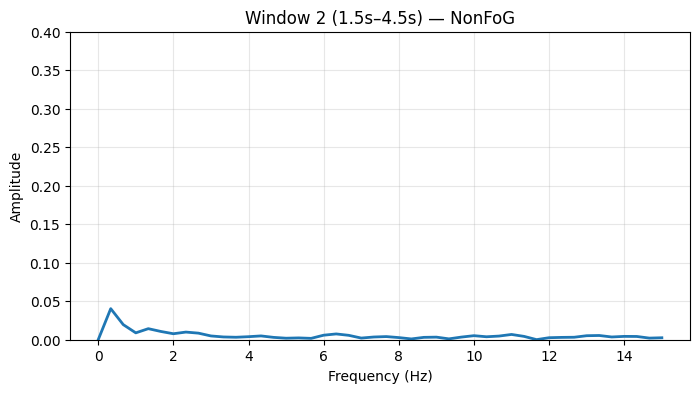

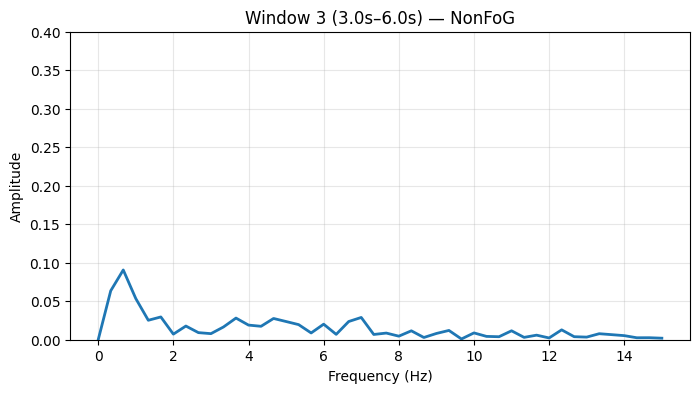

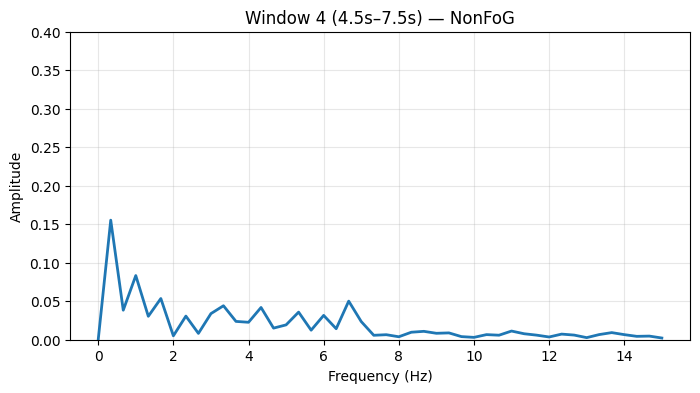

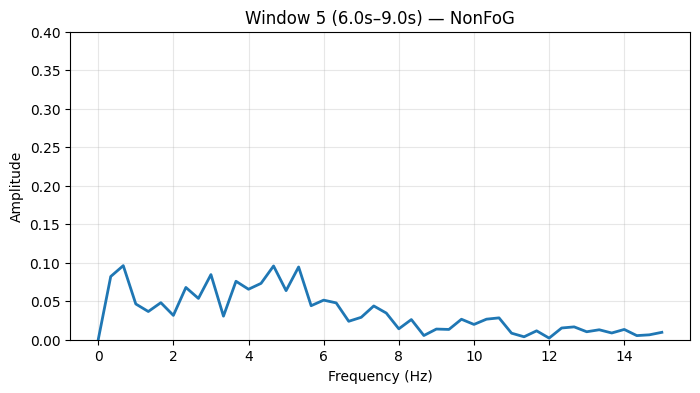

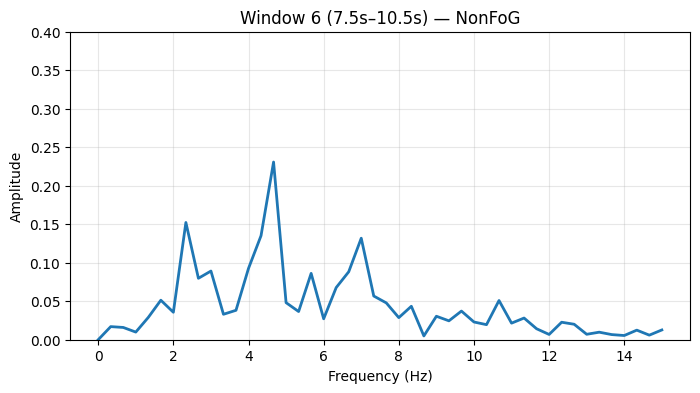

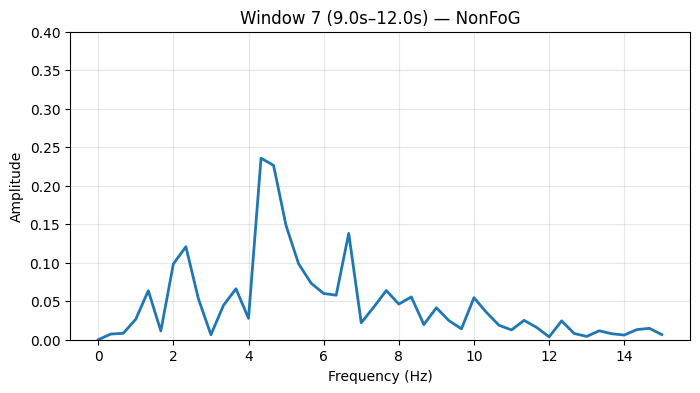

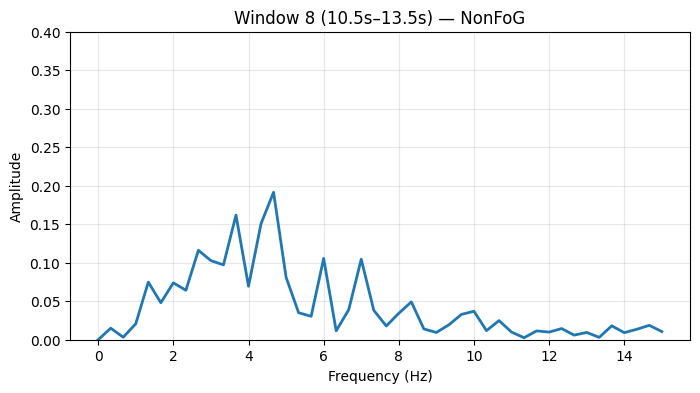

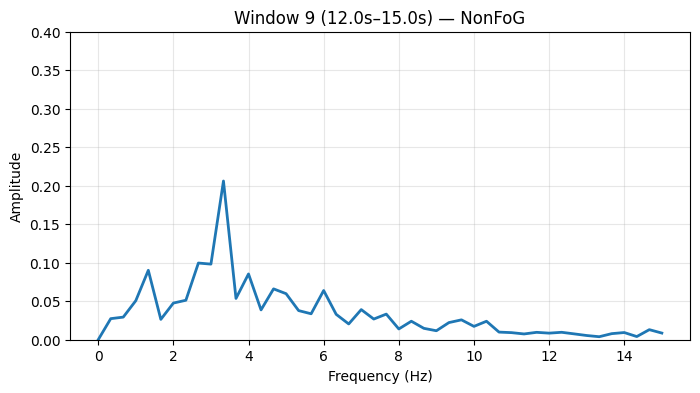

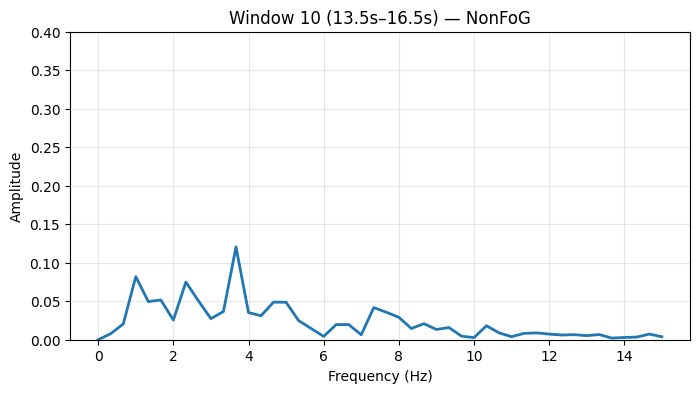

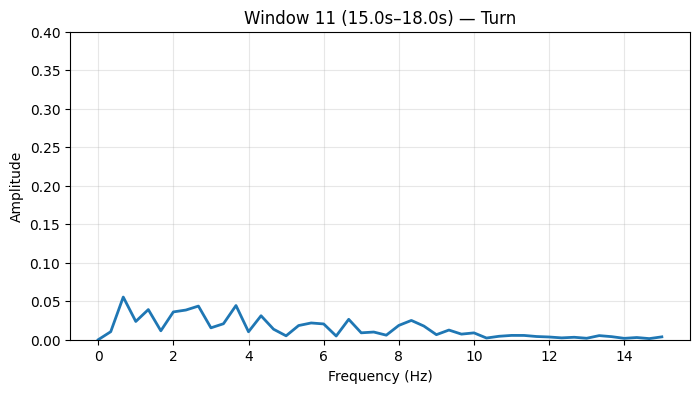

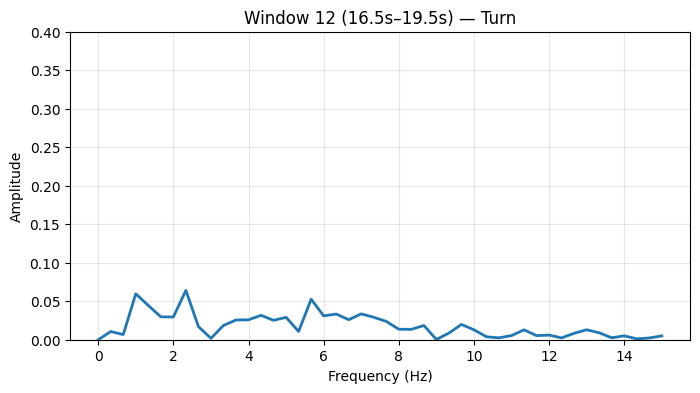

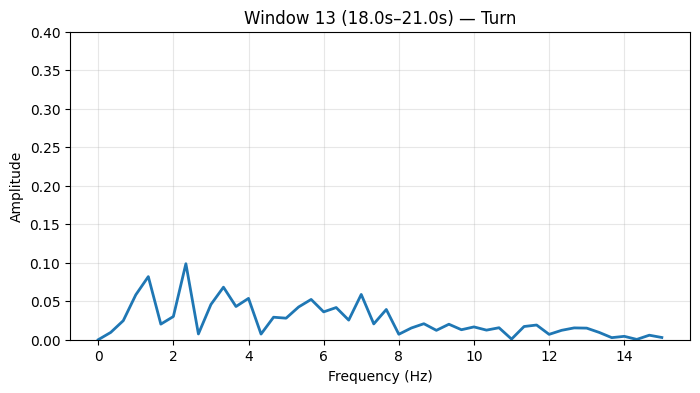

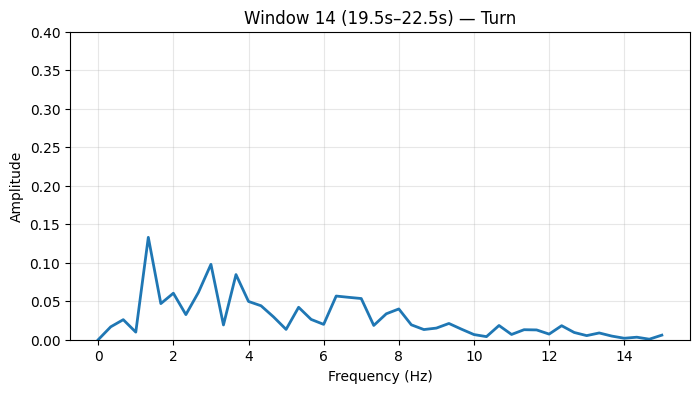

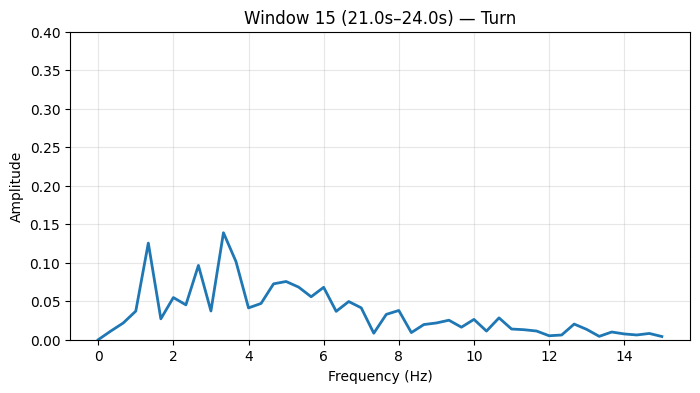

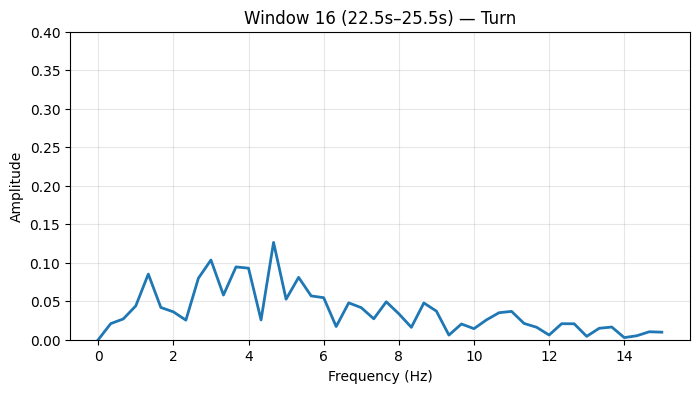

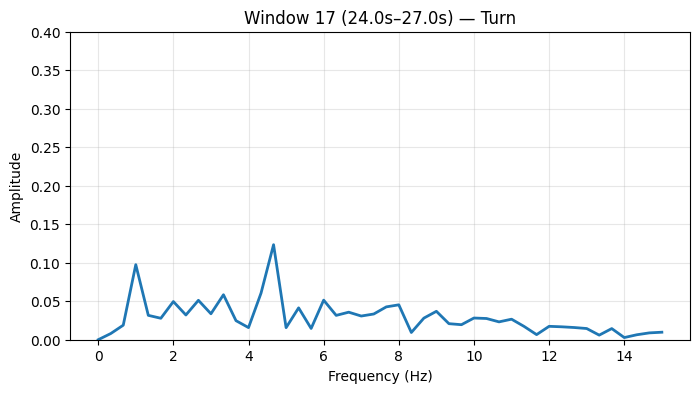

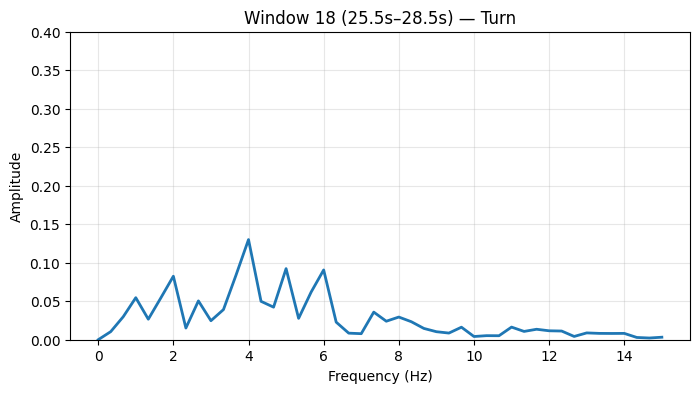

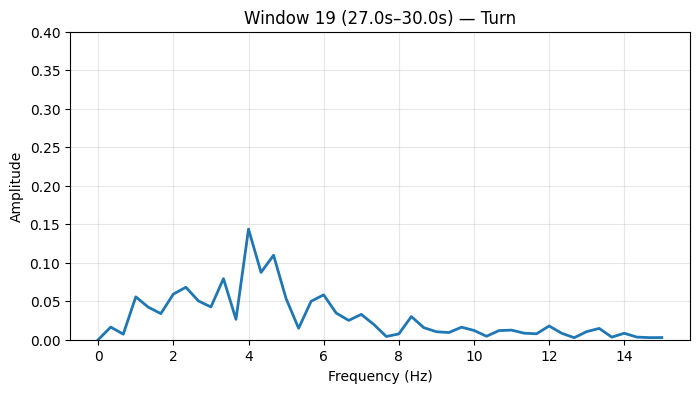

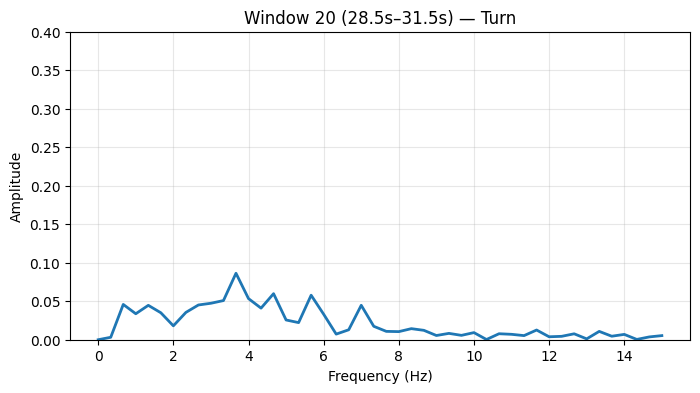

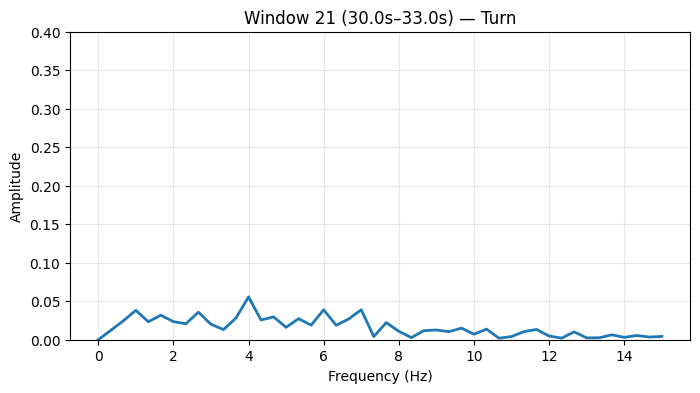

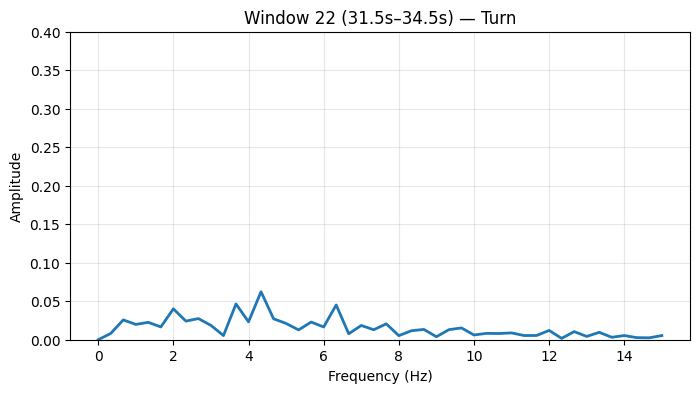

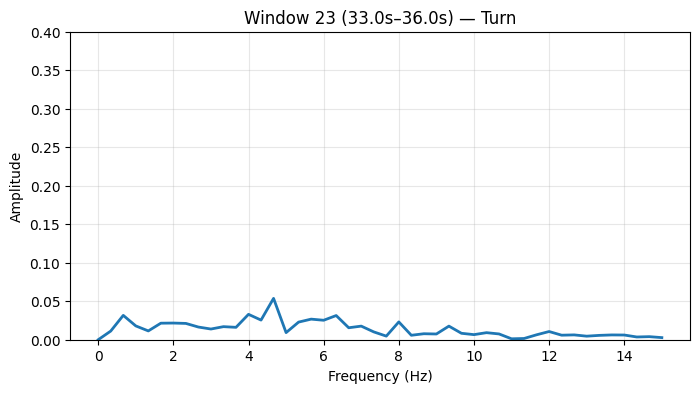

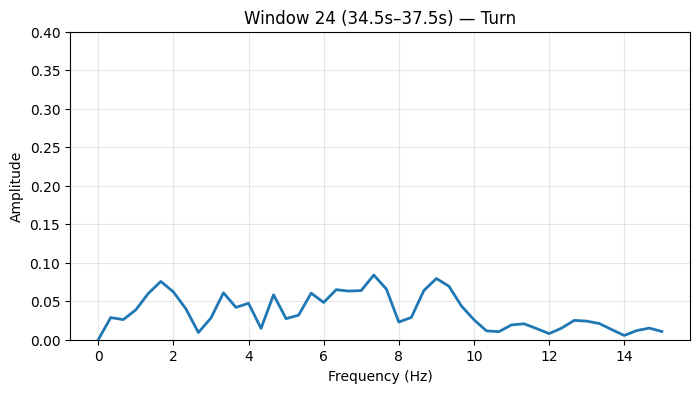

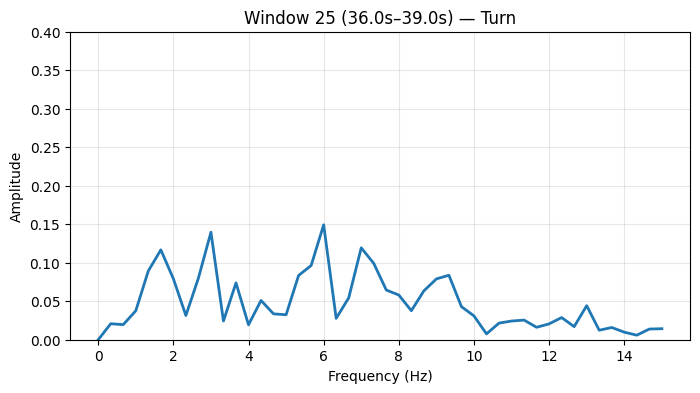

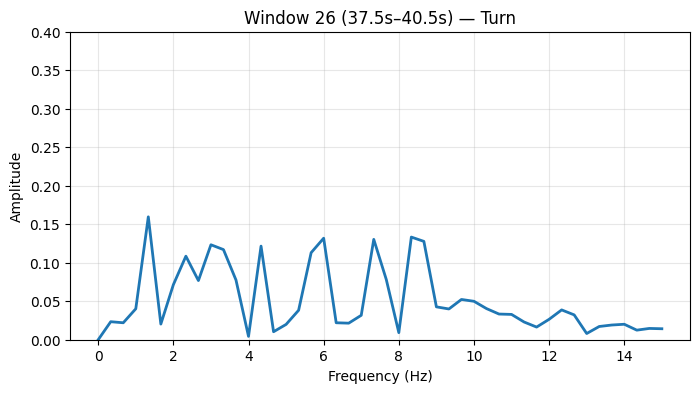

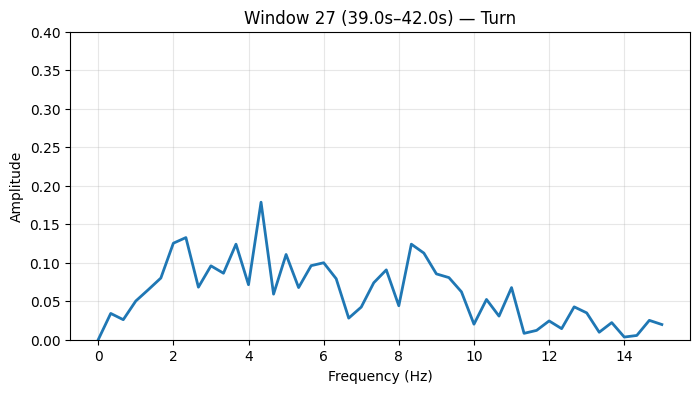

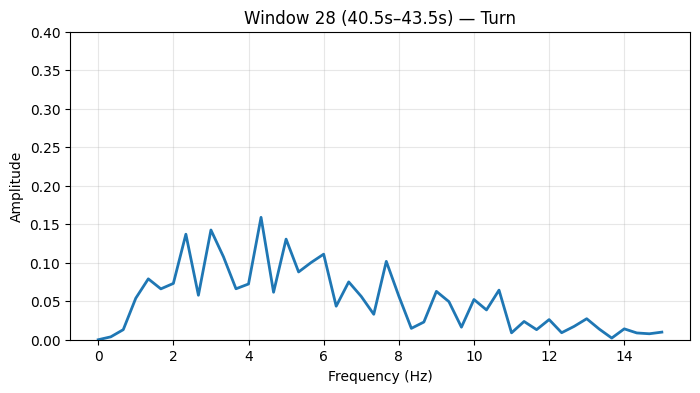

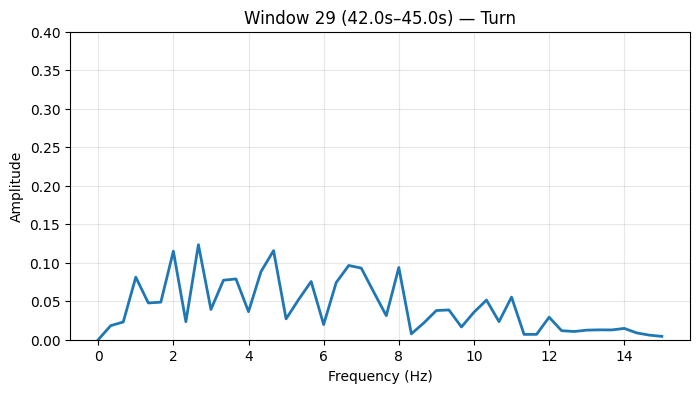

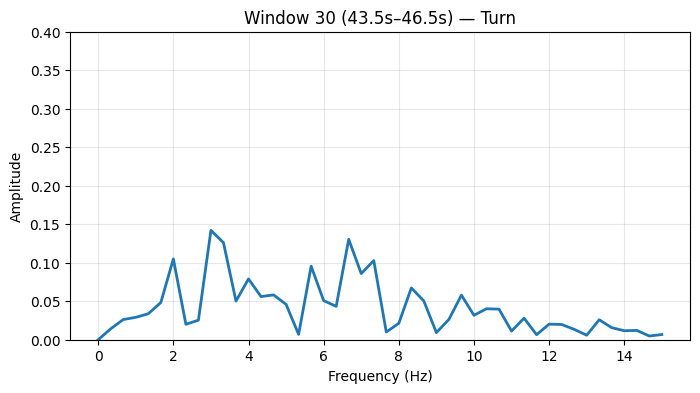

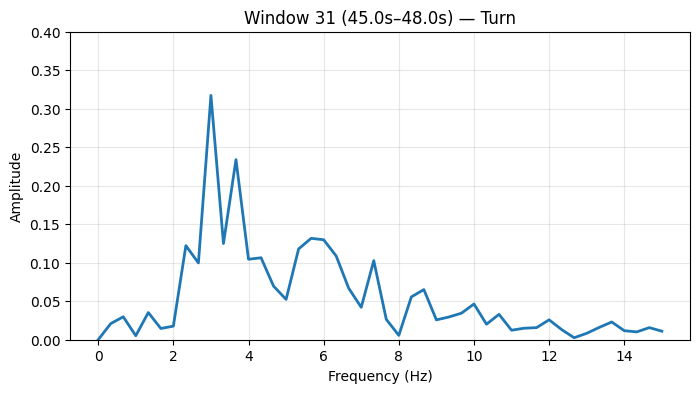

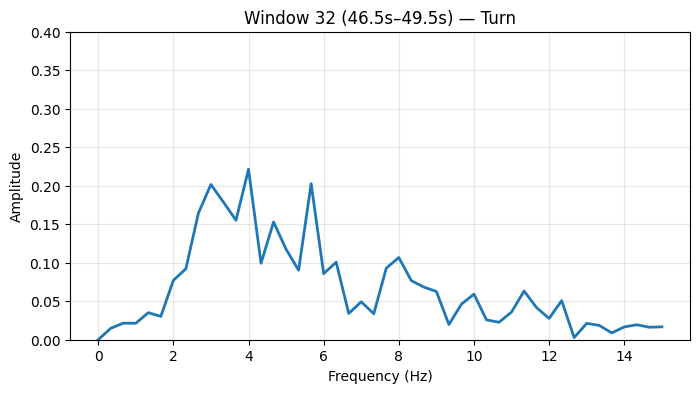

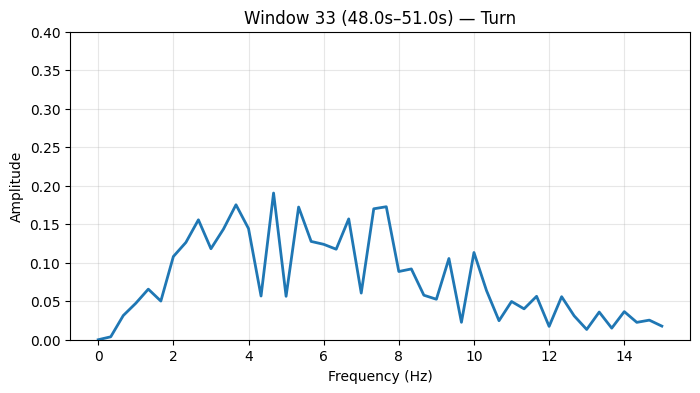

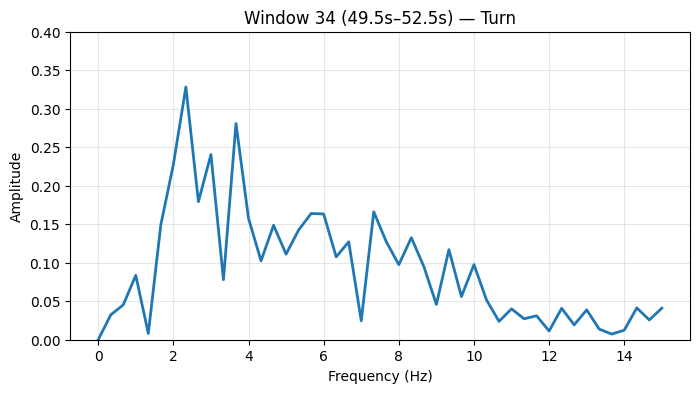

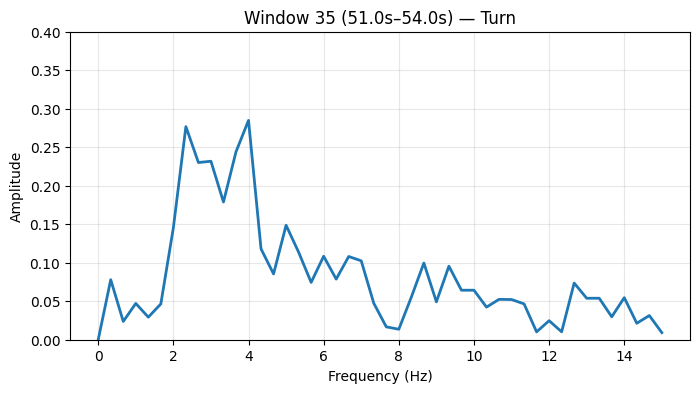

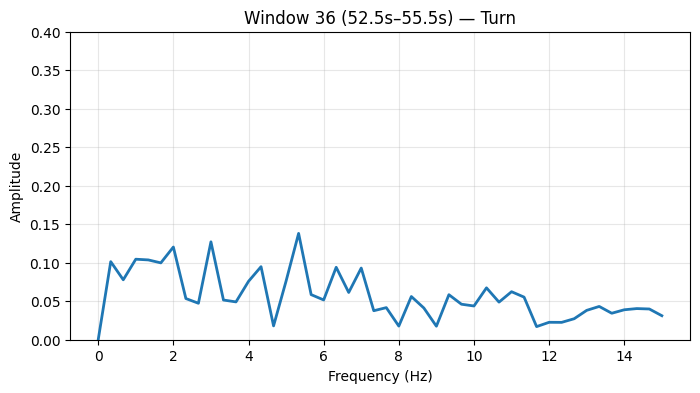

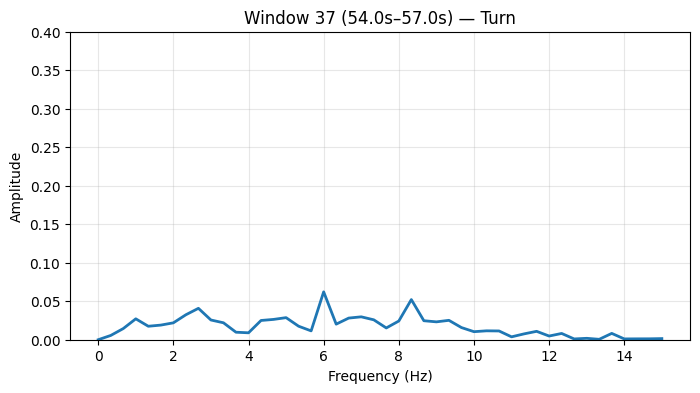

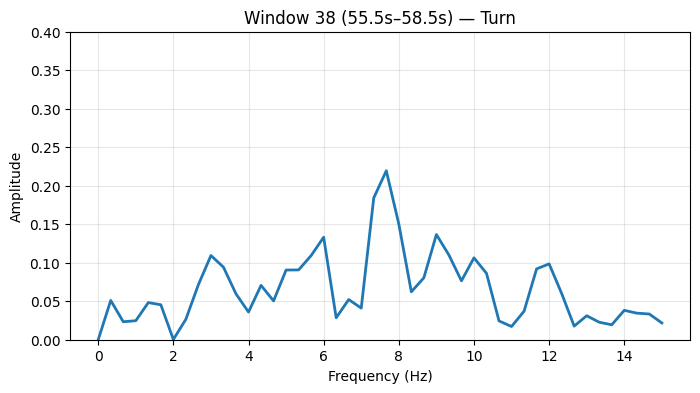

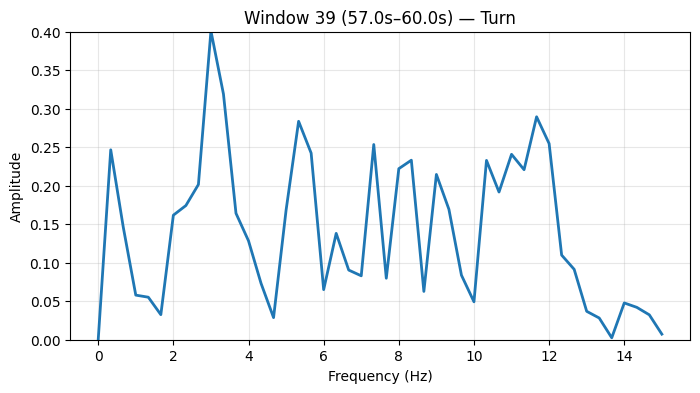

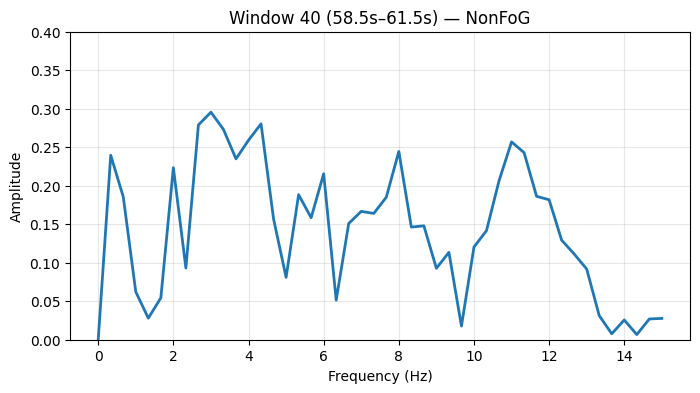

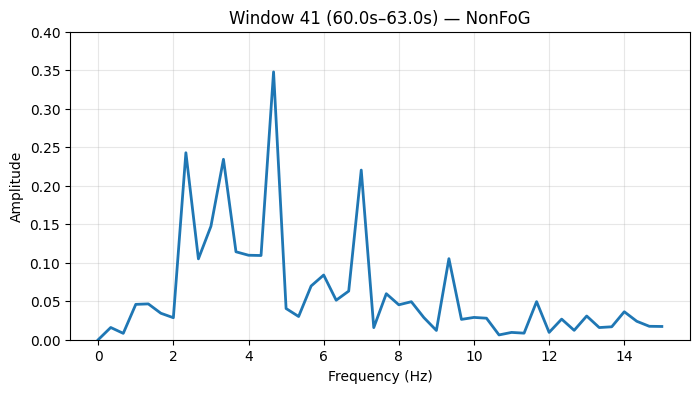

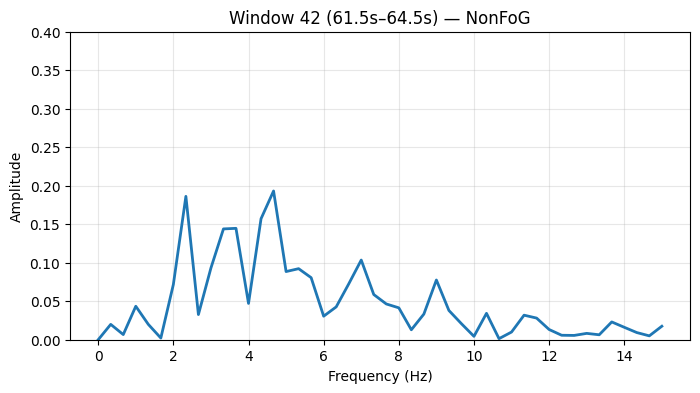

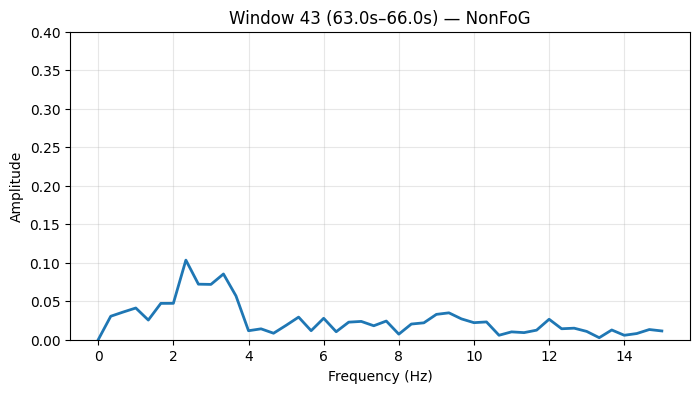

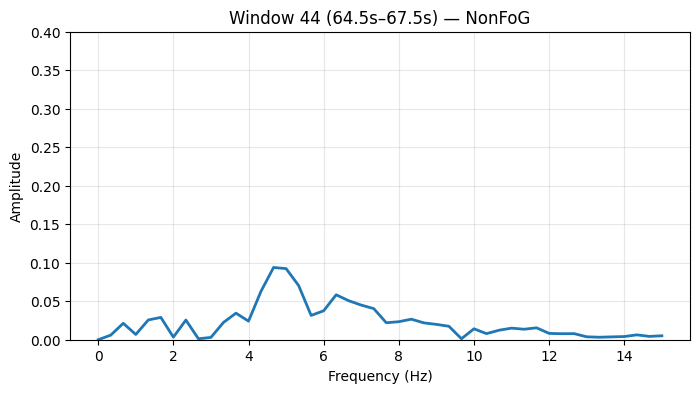

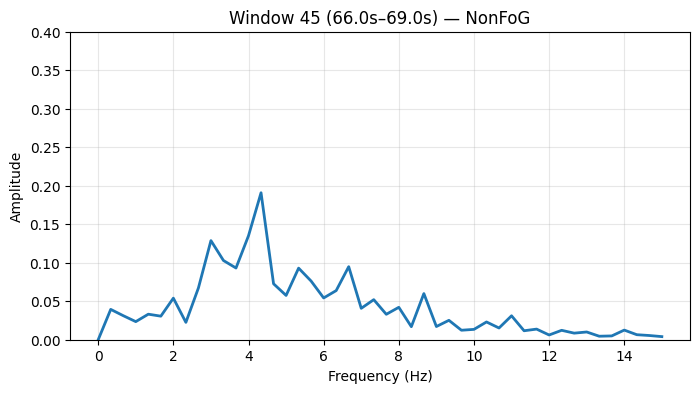

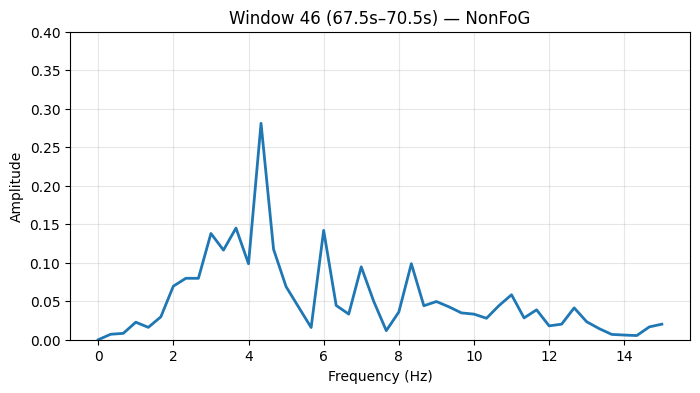

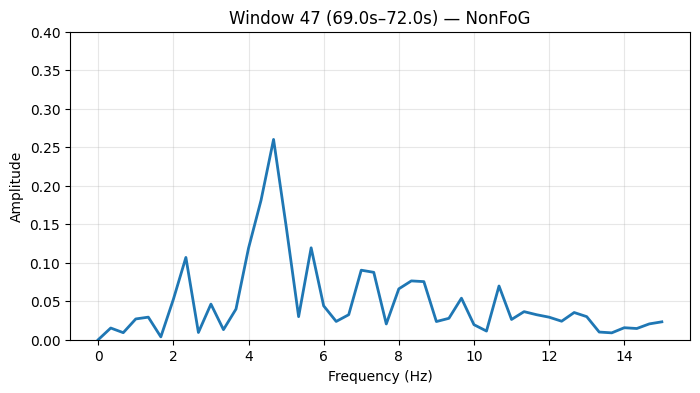

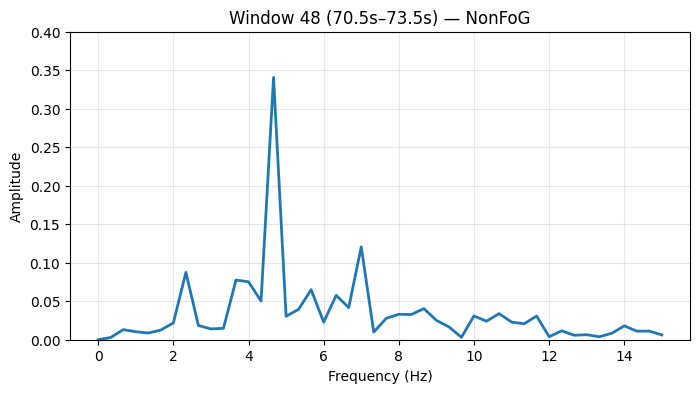

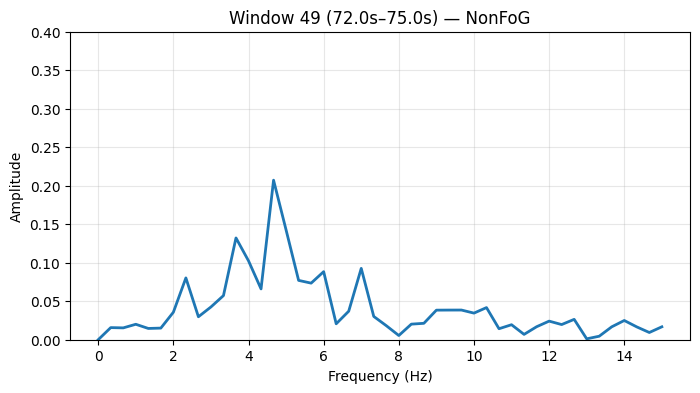

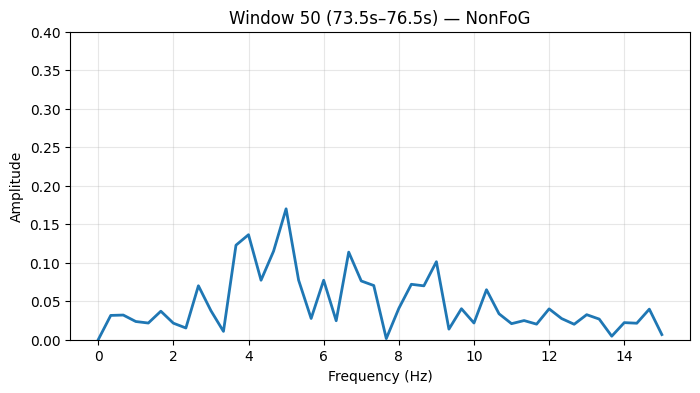

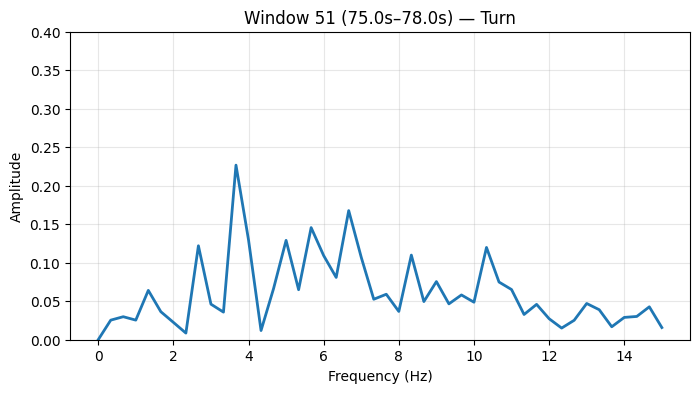

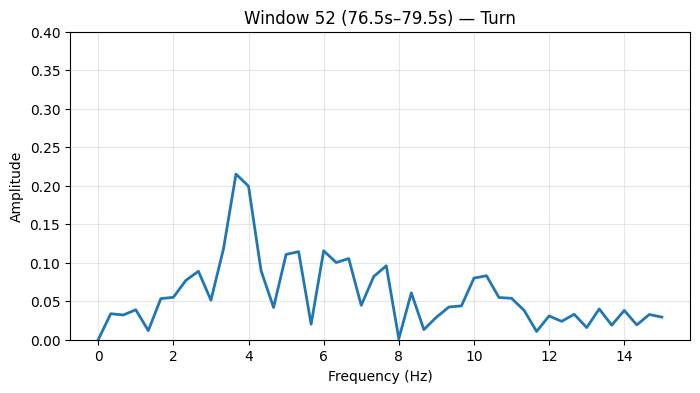

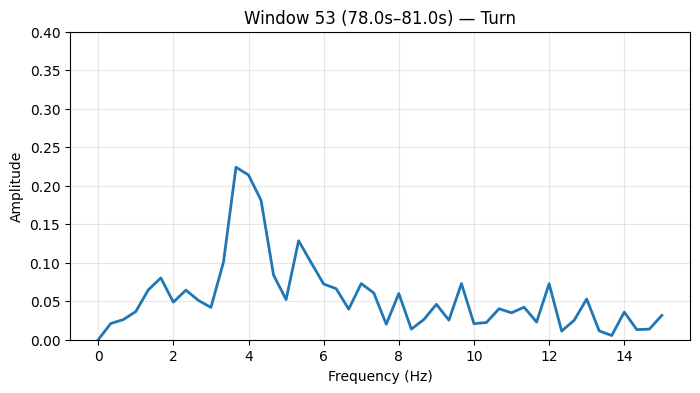

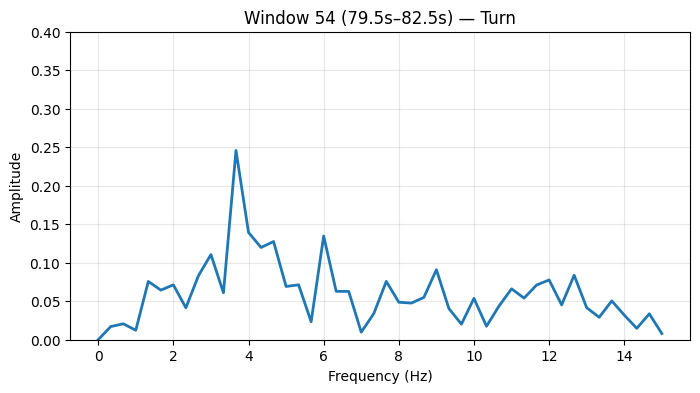

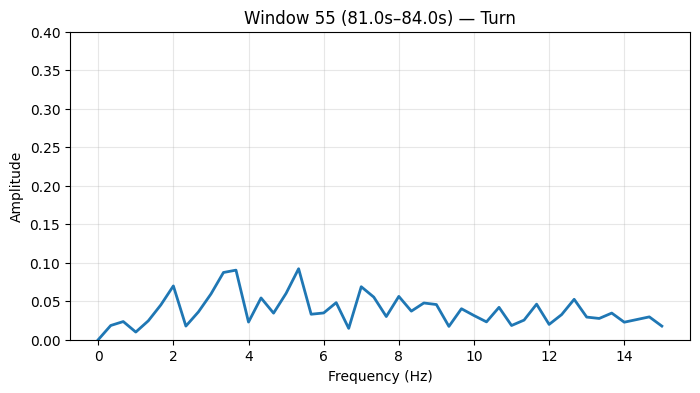

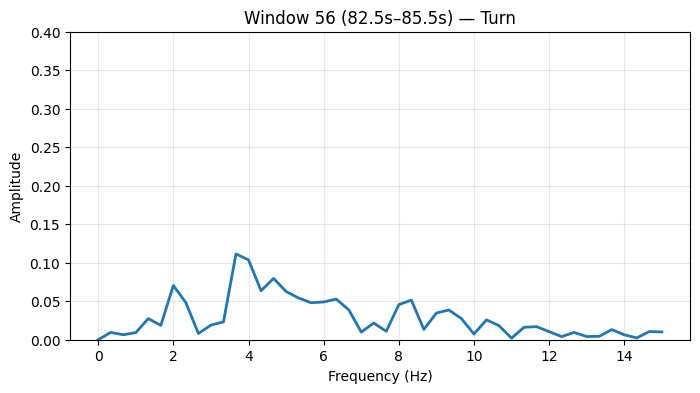

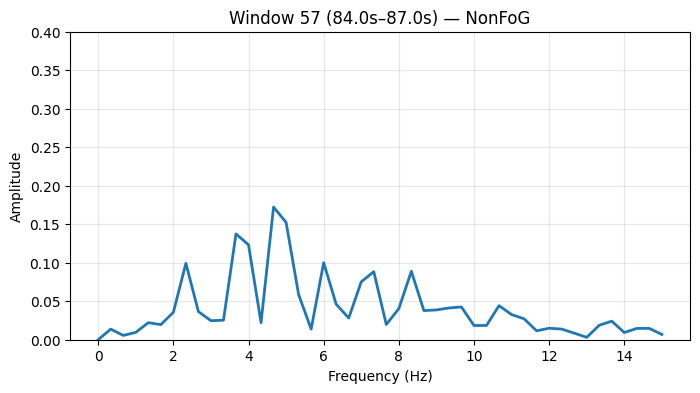

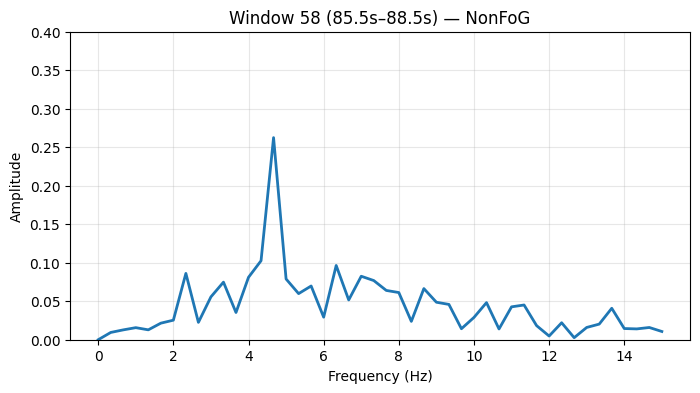

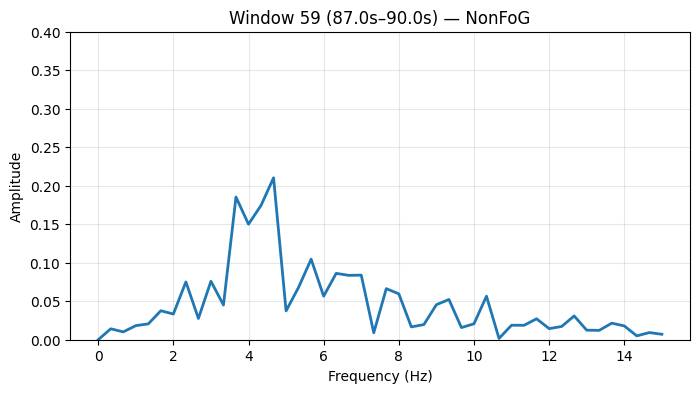

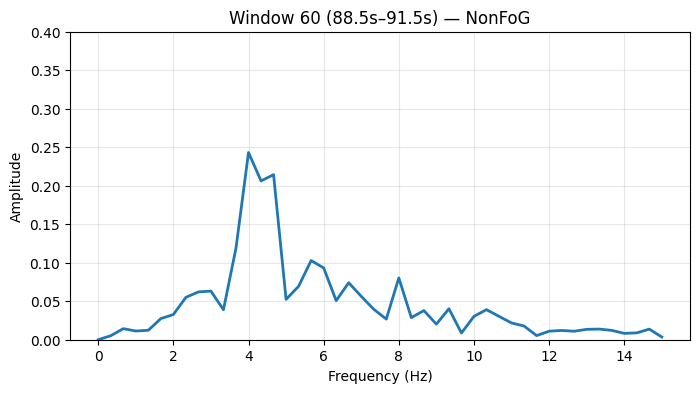

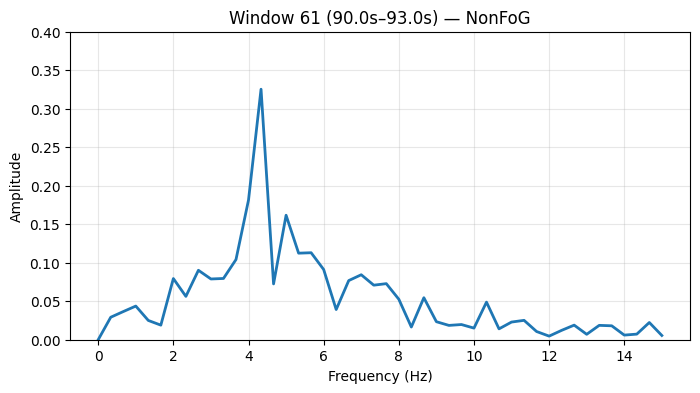

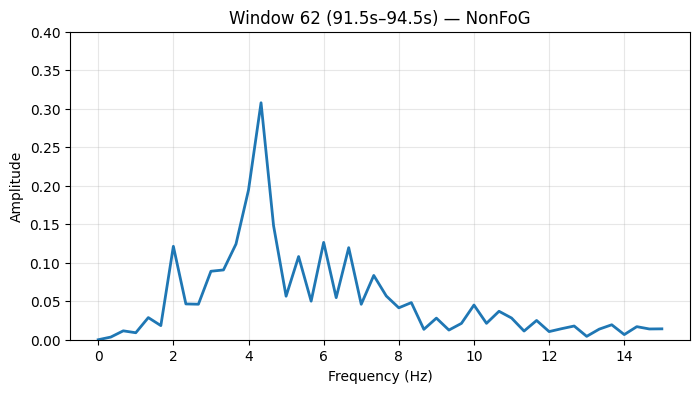

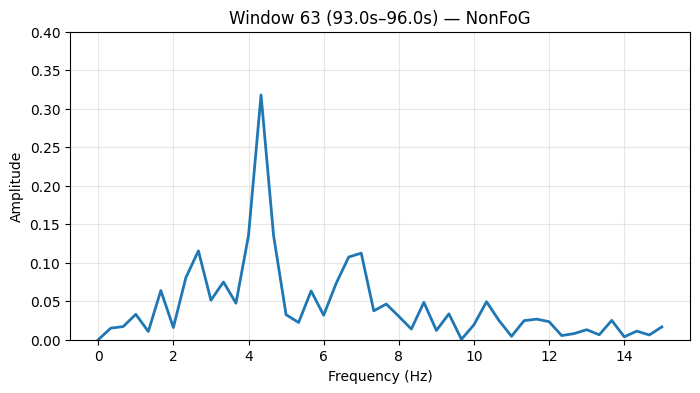

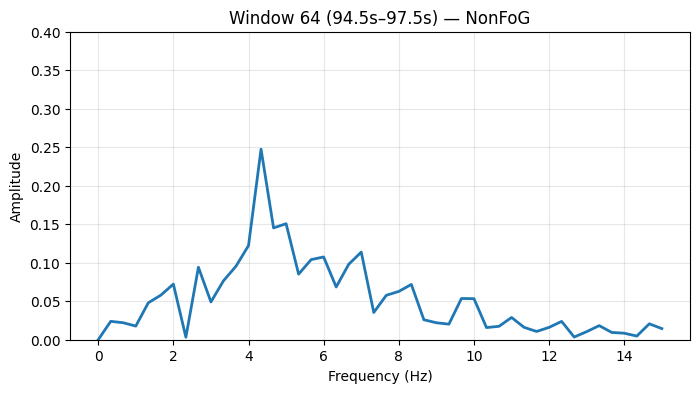

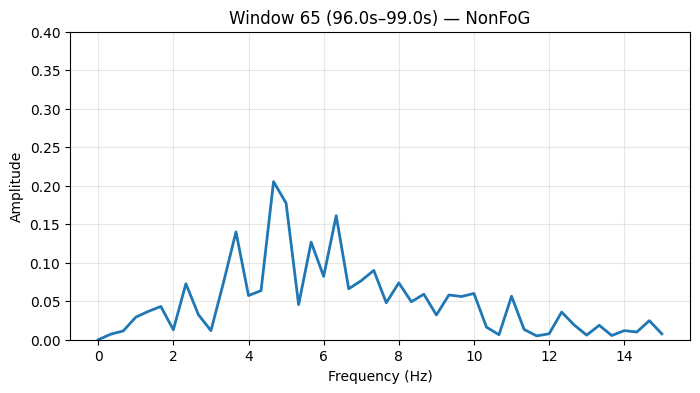

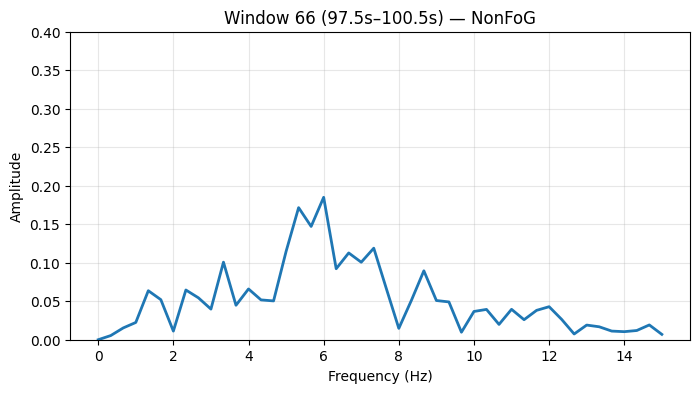

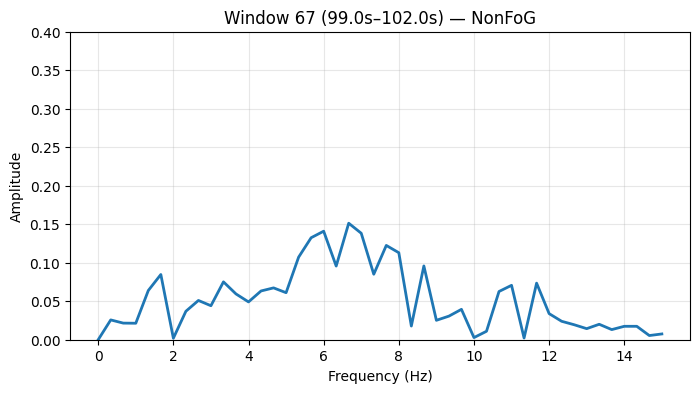

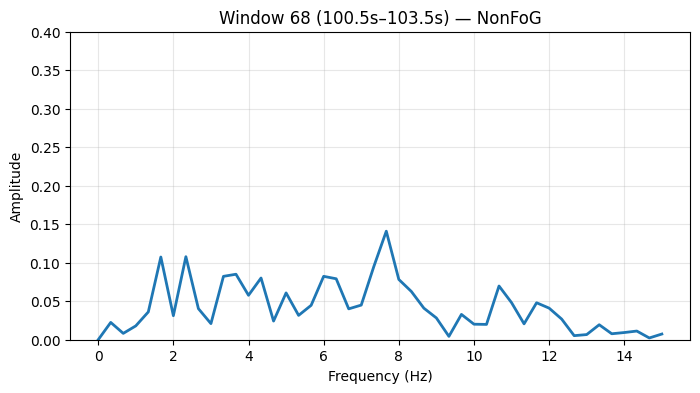

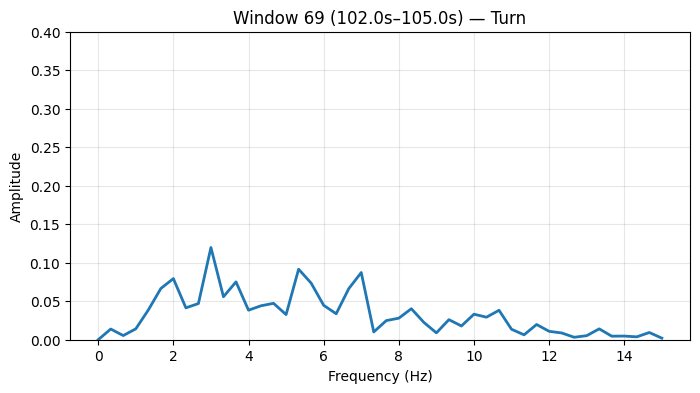

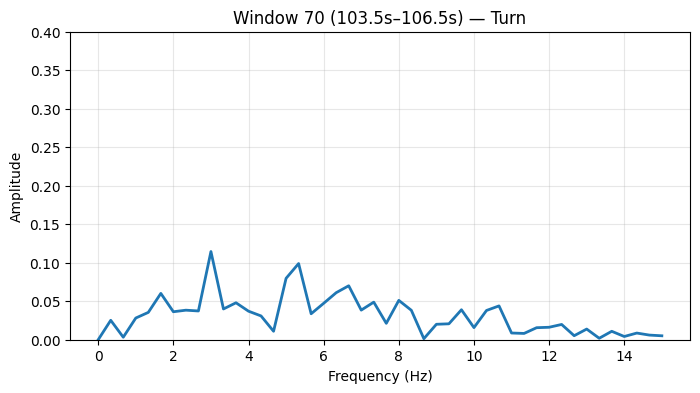

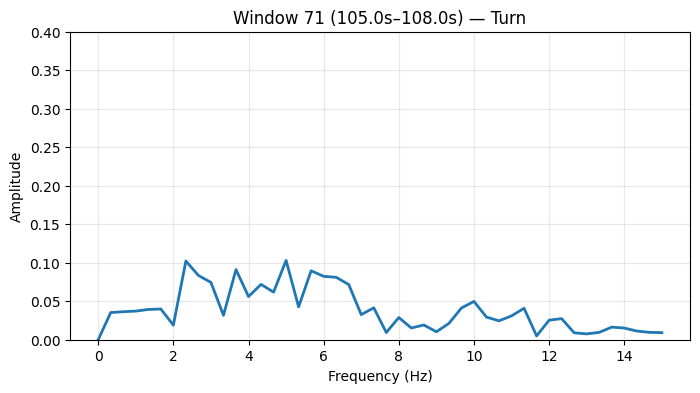

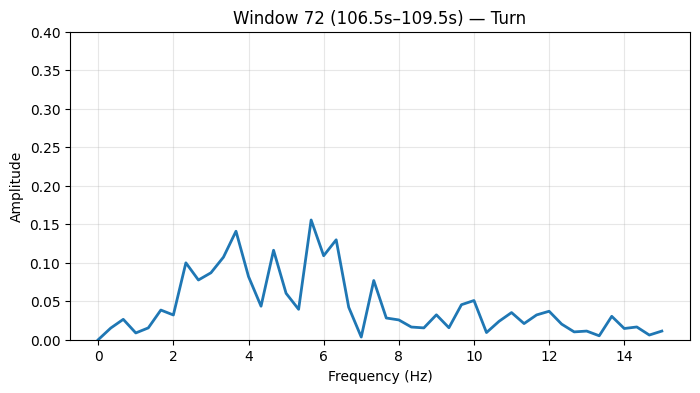

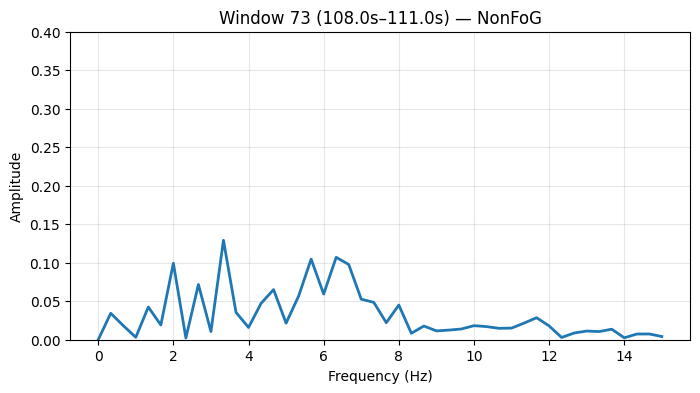

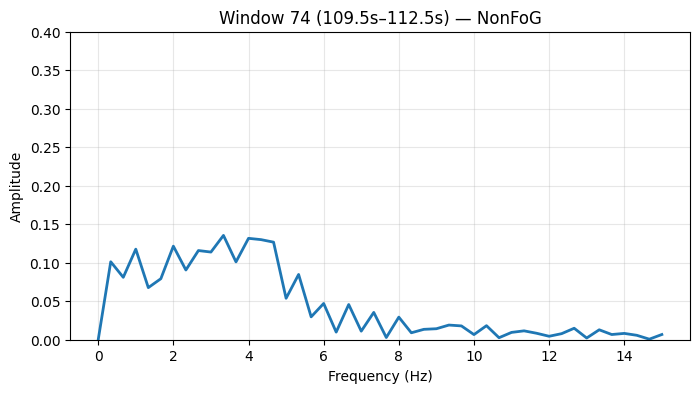

In [14]:
plot_individual_window_ffts(df_1, fs=128)

In [15]:
def compute_fft_window_energy(
    df, 
    fs=128, 
    window_sec=3.0, 
    overlap=0.5,
    fog_fraction_threshold=0.5,
    freq_limit=15
):
    """
    Computes FFT energy features for each window:
        - Magnitude FFT energies
        - Individual axis FFT energies (AccV, AccML, AccAP)
        - One-hot FoG labels
        - Binary label: FoG vs NonFoG
    """

    # 1. Magnitude signal ------------------------------------
    x_mag = accel_magnitude(df)
    x_mag = butter_lowpass_filter(x_mag, cutoff=15, fs=fs)
    x_mag = x_mag - np.mean(x_mag)

    # 1b. Individual axes -------------------------------------
    axes = {
        "V":    df["AccV"].to_numpy(),
        "ML":   df["AccML"].to_numpy(),
        "AP":   df["AccAP"].to_numpy(),
    }
    # Apply same filtering
    for k in axes:
        axes[k] = butter_lowpass_filter(axes[k], cutoff=15, fs=fs)
        axes[k] = axes[k] - np.mean(axes[k])

    # 2. Raw FoG events ---------------------------------------
    fog_cols = [c for c in ["StartHesitation", "Turn", "Walking"] if c in df.columns]
    fog_matrix = df[fog_cols].to_numpy()

    # 3. Windowing --------------------------------------------
    win = int(window_sec * fs)
    hop = int(win * (1 - overlap))
    N = len(x_mag)

    rows = []

    # 4. Loop through windows ---------------------------------
    for s in range(0, N - win, hop):
        e = s + win

        # ---- CLASSIFICATION ----
        window_events = fog_matrix[s:e].mean(axis=0)
        max_idx = np.argmax(window_events)
        max_val = window_events[max_idx]

        if max_val >= fog_fraction_threshold:
            active_event = fog_cols[max_idx]
        else:
            active_event = None

        onehot = {
            "StartHesitation_onehot": 1 if active_event == "StartHesitation" else 0,
            "Turn_onehot":            1 if active_event == "Turn" else 0,
            "Walking_onehot":         1 if active_event == "Walking" else 0,
        }

        binary_label = "FoG" if any(onehot.values()) else "NonFoG"

        # ---- FFT ENERGY FUNCTION ----
        def compute_energy(signal):
            seg = signal[s:e]
            seg = seg - np.mean(seg)

            freqs = np.fft.rfftfreq(len(seg), d=1/fs)
            mag   = np.abs(np.fft.rfft(seg)) / len(seg)

            # limit frequency range
            mask = freqs <= freq_limit
            freqs = freqs[mask]
            mag   = mag[mask]

            # energy bands
            low_mask  = (freqs >= 0.5) & (freqs <= 3)
            high_mask = (freqs > 3)    & (freqs <= 8)

            low  = simpson(mag[low_mask], freqs[low_mask]) if low_mask.sum()>1 else 0
            high = simpson(mag[high_mask], freqs[high_mask]) if high_mask.sum()>1 else 0
            total = simpson(mag, freqs)

            return low, high, total

        # ---- Magnitude FFT energies ----
        low_mag, high_mag, total_mag = compute_energy(x_mag)

        # ---- Per-axis FFT energies ----
        V_low, V_high, V_total     = compute_energy(axes["V"])
        ML_low, ML_high, ML_total  = compute_energy(axes["ML"])
        AP_low, AP_high, AP_total  = compute_energy(axes["AP"])

        # ---- Ratio metrics ----
        energy_ratio = high_mag / low_mag if low_mag > 0 else np.nan
        freeze_index = (high_mag**2) / (low_mag**2) if low_mag > 0 else np.nan

        # ---- Build row ----
        row = {
            "start_time": s / fs,
            "end_time": e / fs,
            "label": binary_label,

            # magnitude features
            "low_energy": low_mag,
            "high_energy": high_mag,
            "total_energy": total_mag,
            "energy_ratio": energy_ratio,
            "freeze_index": freeze_index,

            # V-axis features
            "V_low_energy": V_low,
            "V_high_energy": V_high,
            "V_total_energy": V_total,

            # ML-axis features
            "ML_low_energy": ML_low,
            "ML_high_energy": ML_high,
            "ML_total_energy": ML_total,

            # AP-axis features
            "AP_low_energy": AP_low,
            "AP_high_energy": AP_high,
            "AP_total_energy": AP_total,
        }

        row.update(onehot)
        rows.append(row)

    return pd.DataFrame(rows)

In [16]:
energy_df = compute_fft_window_energy(df_1)
energy_df.head(50)

start_time  end_time   label  low_energy  high_energy  total_energy  \
0          0.0       3.0  NonFoG    0.000774     0.001550      0.004406   
1          1.5       4.5  NonFoG    0.023492     0.017541      0.086616   
2          3.0       6.0  NonFoG    0.065773     0.082776      0.233466   
3          4.5       7.5  NonFoG    0.093193     0.104098      0.332076   
4          6.0       9.0  NonFoG    0.125784     0.252137      0.548933   
5          7.5      10.5  NonFoG    0.145782     0.371793      0.694096   
6          9.0      12.0  NonFoG    0.122812     0.438441      0.718729   
7         10.5      13.5  NonFoG    0.143748     0.369034      0.670074   
8         12.0      15.0  NonFoG    0.136332     0.220660      0.503535   
9         13.5      16.5  NonFoG    0.130141     0.169065      0.373544   
10        15.0      18.0     FoG    0.071352     0.080690      0.210643   
11        16.5      19.5     FoG    0.089543     0.138481      0.287306   
12        18.0      21.0     FoG    0.112557     0.174776      0.394865   
13        19.5      22.5     FoG    0.118745     0.193170      0.421911   
14        21.0      24.0     FoG    0.127247     0.262001      0.507802   
15        22.5      25.5     FoG    0.119765     0.255893      0.552329   
16        24.0      27.0     FoG    0.110983     0.176483      0.429269   
17        25.5      28.5     FoG    0.102544     0.234331      0.424583   
18        27.0      30.0     FoG    0.114258     0.220703      0.433270   
19        28.5      31.5     FoG    0.085967     0.172592      0.325099   
20        30.0      33.0     FoG    0.067555     0.118221      0.249469   
21        31.5      34.5     FoG    0.054816     0.128916      0.243926   
22        33.0      36.0     FoG    0.044614     0.098496      0.202255   
23        34.5      37.5     FoG    0.104671     0.234180      0.550691   
24        36.0      39.0     FoG    0.167413     0.313507      0.740272   
25        37.5      40.5     FoG    0.168622     0.295020      0.787546   
26        39.0      42.0     FoG    0.194468     0.424285      0.975379   
27        40.5      43.5     FoG    0.184717     0.408562      0.812172   
28        42.0      45.0     FoG    0.152834     0.312272      0.637688   
29        43.5      46.5     FoG    0.104673     0.283449      0.621266   
30        45.0      48.0     FoG    0.152082     0.457772      0.884402   
31        46.5      49.5     FoG    0.171483     0.532426      1.037049   
32        48.0      51.0     FoG    0.206415     0.579542      1.149493   
33        49.5      52.5     FoG    0.390828     0.628577      1.442589   
34        51.0      54.0     FoG    0.307283     0.535582      1.264032   
35        52.5      55.5     FoG    0.204989     0.318321      0.899355   
36        54.0      57.0     FoG    0.061536     0.104993      0.260491   
37        55.5      58.5     FoG    0.094661     0.423730      1.002865   
38        57.0      60.0     FoG    0.300159     0.670767      2.181003   
39        58.5      61.5  NonFoG    0.301046     0.824254      2.125609   
40        60.0      63.0  NonFoG    0.209957     0.471340      0.945229   
41        61.5      64.5  NonFoG    0.142831     0.425300      0.767867   
42        63.0      66.0  NonFoG    0.136564     0.107592      0.402933   
43        64.5      67.5  NonFoG    0.036209     0.229641      0.350254   
44        66.0      69.0  NonFoG    0.096542     0.374417      0.643472   
45        67.5      70.5  NonFoG    0.122260     0.418506      0.827871   
46        69.0      72.0  NonFoG    0.086904     0.412895      0.747010   
47        70.5      73.5  NonFoG    0.062964     0.313886      0.510981   
48        72.0      75.0  NonFoG    0.077810     0.370058      0.625952   
49        73.5      76.5  NonFoG    0.075059     0.359118      0.716149   

    energy_ratio  freeze_index  V_low_energy  V_high_energy  V_total_energy  \
0       2.002954      4.011826      0.000753       0.002722        0.006048   
1       0.746696    

In [17]:
pip install tsfresh

Note: you may need to restart the kernel to use updated packages.


In [18]:
from tsfresh import extract_features

extracted_features = extract_features(energy_df, column_id="label", column_sort="start_time")

print(extracted_features)

Feature Extraction: 100%|██████████| 9/9 [00:02<00:00,  4.40it/s]


        end_time__variance_larger_than_standard_deviation  \
FoG                                                   1.0   
NonFoG                                                1.0   

        end_time__has_duplicate_max  end_time__has_duplicate_min  \
FoG                             0.0                          0.0   
NonFoG                          0.0                          0.0   

        end_time__has_duplicate  end_time__sum_values  end_time__abs_energy  \
FoG                         0.0                2050.5             134835.75   
NonFoG                      0.0                2223.0             187924.50   

        end_time__mean_abs_change  end_time__mean_change  \
FoG                      2.407895               2.407895   
NonFoG                   3.220588               3.220588   

        end_time__mean_second_derivative_central  end_time__median  ...  \
FoG                                          0.0              46.5  ...   
NonFoG                                    

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


In [19]:
all_feature_dfs = []

files = glob.glob("/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/train/tdcsfog/*.csv")

for f in files:
    # 1. Load raw accelerometer data
    df = pd.read_csv(f)
    
    # 2. Compute window-level FFT energy features (your function)
    feat_df = compute_fft_window_energy(df)
    
    # 3. Add a series ID column based on the filename
    series_id = os.path.splitext(os.path.basename(f))[0]   # e.g. "04e10e0797"
    feat_df["SeriesId"] = series_id
    
    all_feature_dfs.append(feat_df)

# 4. Combine everything into one big feature table
all_features_df = pd.concat(all_feature_dfs, ignore_index=True)

all_features_df.head()

start_time  end_time   label  low_energy  high_energy  total_energy  \
0         0.0       3.0  NonFoG    0.000725     0.001829      0.004776   
1         1.5       4.5  NonFoG    0.001138     0.001465      0.004675   
2         3.0       6.0  NonFoG    0.000702     0.001253      0.003717   
3         4.5       7.5  NonFoG    0.000673     0.001740      0.004861   
4         6.0       9.0  NonFoG    0.096208     0.129458      0.367906   

   energy_ratio  freeze_index  V_low_energy  V_high_energy  ...  \
0      2.523882      6.369981      0.000714       0.001868  ...   
1      1.288085      1.659162      0.001134       0.001511  ...   
2      1.783360      3.180373      0.000698       0.001276  ...   
3      2.584522      6.679752      0.000669       0.001769  ...   
4      1.345604      1.810650      0.092745       0.138990  ...   

   ML_low_energy  ML_high_energy  ML_total_energy  AP_low_energy  \
0       0.001067        0.003844         0.008884       0.001544   
1       0.000775        0.003535         0.007499       0.001691   
2       0.000880        0.003903         0.007938       0.001496   
3       0.001231        0.004794         0.010964       0.001281   
4       0.048663        0.042008         0.178810       0.233641   

   AP_high_energy  AP_total_energy  StartHesitation_onehot  Turn_onehot  \
0        0.011433         0.016869                       0            0   
1        0.007571         0.013968                       0            0   
2        0.011021         0.017480                       0            0   
3        0.011757         0.021719                       0            0   
4        0.223384         0.696324                       0            0   

   Walking_onehot    SeriesId  
0               0  a171e61840  
1               0  a171e61840  
2               0  a171e61840  
3               0  a171e61840  
4               0  a171e61840  

[5 rows x 21 columns]

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [21]:
def build_polars(
    features_df,
    id_col="SeriesId",          # your series identifier
    label_col="label",          # "FoG"/"NonFoG"
    feature_cols=None,
):
    """
    Convert a window-level features dataframe into RNN-ready sequences
    using Polars to group by `id_col`.

    Returns:
        X_seqs: list of (T, F) arrays
        y_seqs: list of (T,) arrays
        grouped: Polars DataFrame with one row per sequence
    """

    # If you don't pass feature_cols, pick a default set
    if feature_cols is None:
        feature_cols = [
            "low_energy", "high_energy", "total_energy",
            "energy_ratio", "freeze_index",
            "V_low_energy", "V_high_energy", "V_total_energy",
            "ML_low_energy", "ML_high_energy", "ML_total_energy",
            "AP_low_energy", "AP_high_energy", "AP_total_energy",
        ]

    # 1. Convert pandas → Polars
    pl_df = pl.DataFrame(features_df)

    # 2. Sort by id and time
    pl_df = pl_df.sort([id_col, "start_time"])

    # 3. Make binary FoG label
    pl_df = pl_df.with_columns(
        (pl.col(label_col) == "FoG").cast(pl.Int8).alias("label_bin")
    )

    # 4. Group by sequence id and aggregate each feature as a list
    agg_exprs = [pl.col(c).alias(c) for c in feature_cols]  # <-- fixed here
    agg_exprs.append(pl.col("label_bin").alias("label_seq"))

    grouped = pl_df.group_by(id_col, maintain_order=True).agg(agg_exprs)

    # 5. Convert grouped rows into numpy arrays per sequence
    X_seqs = []
    y_seqs = []

    for row in grouped.iter_rows(named=True):
        # Build (T, F) feature matrix
        feature_lists = [row[c] for c in feature_cols]  # each is a list over time
        feats = np.stack(
            [np.array(v, dtype=np.float32) for v in feature_lists],
            axis=-1,  # shape: (T, F)
        )

        labels = np.array(row["label_seq"], dtype=np.int64)  # shape: (T,)

        X_seqs.append(feats)
        y_seqs.append(labels)

    return X_seqs, y_seqs, grouped

In [22]:
X_seqs, y_seqs, grouped_meta = build_polars(
    all_features_df,
    id_col="SeriesId",
    label_col="label",      # "FoG"/"NonFoG"
)

print(len(X_seqs), "sequences")
print(X_seqs[0].shape, y_seqs[0].shape)  # (T, F), (T,)

833 sequences
(23, 14) (23,)


In [23]:
# 1. Check some sequence lengths distribution
lengths = [x.shape[0] for x in X_seqs]
print("min T:", min(lengths), "max T:", max(lengths), "mean T:", np.mean(lengths))

# 2. Check label balance
all_labels = np.concatenate(y_seqs)
unique, counts = np.unique(all_labels, return_counts=True)
print(dict(zip(unique, counts)))  # 0 = NonFoG, 1 = FoG

min T: 11 max T: 504 mean T: 42.63025210084034
{0: 24206, 1: 11305}


In [24]:
print("CUDA available?", torch.cuda.is_available())
print("Device count:", torch.cuda.device_count())
print("Device name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU only")

CUDA available? True
Device count: 2
Device name: Tesla T4


In [25]:
class FoGSequenceDataset(Dataset):
    def __init__(self, X_seqs, y_seqs):
        assert len(X_seqs) == len(y_seqs)
        self.X_seqs = X_seqs
        self.y_seqs = y_seqs

    def __len__(self):
        return len(self.X_seqs)

    def __getitem__(self, idx):
        x = torch.from_numpy(self.X_seqs[idx]).float()   # (T, F)
        y = torch.from_numpy(self.y_seqs[idx]).long()    # (T,)
        return x, y

In [26]:
def collate_fn(batch):
    xs, ys = zip(*batch)   # lists of tensors of different lengths

    lengths = torch.tensor([x.size(0) for x in xs], dtype=torch.long)  # (B,)

    # Pad along time dimension → (B, T_max, F) and (B, T_max)
    xs_padded = pad_sequence(xs, batch_first=True)  # (B, T_max, F)
    ys_padded = pad_sequence(ys, batch_first=True)  # (B, T_max)

    # Build mask: True where there is real data, False where padding
    B, T_max, _ = xs_padded.shape
    mask = torch.arange(T_max).unsqueeze(0) < lengths.unsqueeze(1)  # (B, T_max)

    return xs_padded.to(device), ys_padded.to(device), lengths.to(device), mask.to(device)

In [27]:
from sklearn.model_selection import train_test_split

indices = np.arange(len(X_seqs))
train_idx, val_idx = train_test_split(indices, test_size=0.2, random_state=42, shuffle=True)

X_train = [X_seqs[i] for i in train_idx]
y_train = [y_seqs[i] for i in train_idx]
X_val   = [X_seqs[i] for i in val_idx]
y_val   = [y_seqs[i] for i in val_idx]

train_dataset = FoGSequenceDataset(X_train, y_train)
val_dataset   = FoGSequenceDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

In [28]:
class FoGGRU(nn.Module):
    def __init__(self, feature_dim, hidden_dim=64, num_layers=1, bidirectional=True):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.bidirectional = bidirectional

        self.gru = nn.GRU(
            input_size=feature_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional,
        )

        out_dim = hidden_dim * (2 if bidirectional else 1)
        self.fc = nn.Linear(out_dim, 1)  # per-timestep FoG logit

    def forward(self, x, lengths):
        # x: (B, T, F)
        # lengths: (B,)

        # Pack to ignore padded timesteps in the GRU
        packed = pack_padded_sequence(
            x, lengths.cpu(), batch_first=True, enforce_sorted=False
        )

        packed_out, _ = self.gru(packed)

        # Unpack back to (B, T, H * num_directions)
        out, _ = pad_packed_sequence(packed_out, batch_first=True)  # (B, T, H*)

        # Project to logits
        logits = self.fc(out).squeeze(-1)  # (B, T)

        return logits

In [29]:
feature_dim = X_seqs[0].shape[1]   # e.g. 14
model = FoGGRU(feature_dim=feature_dim, hidden_dim=64, num_layers=1, bidirectional=True)
model = model.to(device)

criterion = nn.BCEWithLogitsLoss(reduction="none")  # we'll mask padding ourselves
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [30]:
from sklearn.metrics import precision_score, recall_score, f1_score
def train_one_epoch(model, loader, optimizer):
    model.train()
    total_loss = 0.0
    total_steps = 0

    for xs, ys, lengths, mask in loader:
        # xs: (B, T, F)
        # ys: (B, T)
        # mask: (B, T) bool

        optimizer.zero_grad()

        logits = model(xs, lengths)            # (B, T)
        ys_float = ys.float()                  # BCE wants float targets

        # Compute raw loss per time-step
        loss_raw = criterion(logits, ys_float)  # (B, T)

        # Apply mask: only count real timesteps
        loss_masked = loss_raw * mask.float()   # (B, T)
        loss = loss_masked.sum() / mask.float().sum()

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_steps += 1

    return total_loss / total_steps


@torch.no_grad()
def eval_one_epoch(model, loader):
    model.eval()
    total_loss = 0.0
    total_steps = 0
    
    all_preds = []
    all_labels = []
    
    for xs, ys, lengths, mask in loader:
        logits = model(xs, lengths)        # (B, T)
        ys_float = ys.float()
        
        loss_raw = criterion(logits, ys_float)
        loss_masked = loss_raw * mask.float()
        loss = loss_masked.sum() / mask.float().sum()
        
        total_loss += loss.item()
        total_steps += 1
        
        # --- Metrics collection ---
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).long()
        
        valid_mask = mask.bool()
        all_preds.append(preds[valid_mask].cpu())
        all_labels.append(ys[valid_mask].cpu())

    # --- Final Calculation ---
    all_preds_np = torch.cat(all_preds).numpy()
    all_labels_np = torch.cat(all_labels).numpy()
    
    accuracy = (all_preds_np == all_labels_np).mean()
    
    # Calculate Precision and Recall
    # zero_division=0 prevents errors if the model predicts no positives
    precision = precision_score(all_labels_np, all_preds_np, zero_division=0)
    recall = recall_score(all_labels_np, all_preds_np, zero_division=0)
    
    return total_loss / total_steps, accuracy, precision, recall

In [31]:
import copy # Needed to save the best model weights

# 1. SETUP EARLY STOPPING CONFIG
num_epochs = 20           # Increase this (e.g., 20)
patience = 5              # Stop if no improvement after 5 epochs
best_val_loss = float('inf')
counter = 0
best_model_wts = None

print("Starting training with Early Stopping...")

for epoch in range(1, num_epochs + 1):
    # Train and Evaluate
    train_loss = train_one_epoch(model, train_loader, optimizer)
    val_loss, val_acc, val_prec, val_rec = eval_one_epoch(model, val_loader)
    
    # Print Metrics
    print(f"Epoch {epoch:<3} | "
          f"Train Loss: {train_loss:.4f} | "
          f"Val Loss: {val_loss:.4f} | "
          f"Val Acc: {val_acc:.4f} | "
          f"Val Prec: {val_prec:.4f} | "
          f"Val Rec: {val_rec:.4f}")

    # 2. EARLY STOPPING CHECK (At the bottom of the loop)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_wts = copy.deepcopy(model.state_dict()) # Save best weights
        counter = 0
        print(f"    --> Best model saved (Loss: {best_val_loss:.4f})")
    else:
        counter += 1
        print(f"    --> No improvement. Patience: {counter}/{patience}")
        if counter >= patience:
            print("Early Stopping Triggered!")
            break

# Load the best weights back into the model
if best_model_wts:
    model.load_state_dict(best_model_wts)
print(f"Training Complete. Best Validation Loss: {best_val_loss:.4f}")

Starting training with Early Stopping...
Epoch 1   | Train Loss: 0.5651 | Val Loss: 0.5569 | Val Acc: 0.7179 | Val Prec: 0.9491 | Val Rec: 0.3366
    --> Best model saved (Loss: 0.5569)
Epoch 2   | Train Loss: 0.4426 | Val Loss: 0.4284 | Val Acc: 0.8506 | Val Prec: 0.8945 | Val Rec: 0.7247
    --> Best model saved (Loss: 0.4284)
Epoch 3   | Train Loss: 0.3993 | Val Loss: 0.3915 | Val Acc: 0.8671 | Val Prec: 0.8918 | Val Rec: 0.7727
    --> Best model saved (Loss: 0.3915)
Epoch 4   | Train Loss: 0.3715 | Val Loss: 0.3801 | Val Acc: 0.8722 | Val Prec: 0.9263 | Val Rec: 0.7510
    --> Best model saved (Loss: 0.3801)
Epoch 5   | Train Loss: 0.3595 | Val Loss: 0.3725 | Val Acc: 0.8740 | Val Prec: 0.9406 | Val Rec: 0.7424
    --> Best model saved (Loss: 0.3725)
Epoch 6   | Train Loss: 0.3486 | Val Loss: 0.3581 | Val Acc: 0.8795 | Val Prec: 0.9559 | Val Rec: 0.7433
    --> Best model saved (Loss: 0.3581)
Epoch 7   | Train Loss: 0.3393 | Val Loss: 0.3414 | Val Acc: 0.8844 | Val Prec: 0.9445 | 

RNN Data collected for ROC Curve.


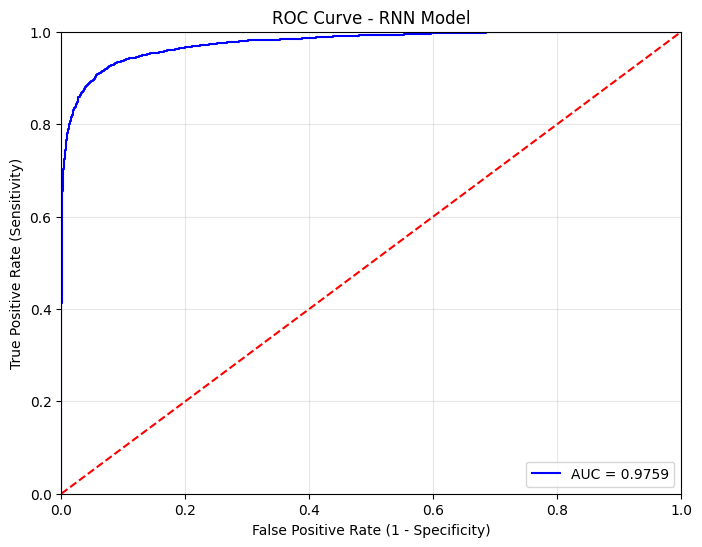

In [32]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import torch

# Create lists to hold data for the whole validation set
all_targets = []
all_probs = [] 

model.eval()
with torch.no_grad():
    # UPDATED: Unpack 4 items (xs, ys, lengths, mask) to match your collate_fn
    for inputs, targets, lengths, mask in val_loader:
        
        # UPDATED: Pass 'lengths' to the model because your RNN expects it
        logits = model(inputs, lengths)
        
        # Get Probabilities (0.0 to 1.0)
        probs = torch.sigmoid(logits)
        
        # Select only real data using the mask provided by the loader
        # We assume 'mask' is already boolean based on your screenshot
        valid_probs = torch.masked_select(probs, mask).cpu().numpy()
        valid_targets = torch.masked_select(targets, mask).cpu().numpy()
        
        all_probs.extend(valid_probs)
        all_targets.extend(valid_targets)

print("RNN Data collected for ROC Curve.")

# --- Plotting Section ---
fpr, tpr, thresholds = roc_curve(all_targets, all_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.title('ROC Curve - RNN Model')
plt.plot(fpr, tpr, 'b', label = f'AUC = {roc_auc:.4f}') 
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--') # Red dashed line: Random guessing
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate (Sensitivity)')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.grid(True, alpha=0.3)
plt.show()

In [33]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
import numpy as np

# 1. Define the CNN Model
class FoGCNN(nn.Module):
    def __init__(self, input_dim):
        super(FoGCNN, self).__init__()
        
        # A 1D Convolution slides over the time axis.
        # input_dim: Number of features (columns in your dataframe)
        # 64: The number of filters (new features the model learns)
        # kernel_size=5: The model looks at 5 timesteps at once
        # padding='same': Ensures output length equals input length
        self.conv1 = nn.Conv1d(in_channels=input_dim, out_channels=64, kernel_size=5, padding='same')
        self.relu = nn.ReLU() # Activation function (adds non-linearity)
        
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=32, kernel_size=3, padding='same')
        
        # Final layer to squash data down to 1 number (probability of Fog)
        self.classifier = nn.Conv1d(in_channels=32, out_channels=1, kernel_size=1)

    def forward(self, x, lengths=None):
        # Input x shape: (Batch, Time, Features)
        # CNNs expect: (Batch, Features, Time)
        x = x.transpose(1, 2) 
        
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.classifier(x)
        
        # Remove the extra dimension to get shape (Batch, Time)
        return x.squeeze(1)

print("CNN Model defined successfully!")

CNN Model defined successfully!


In [34]:
# Check if GPU is available (like your teammate's screenshot)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 2. Split Data using Sklearn
# We use indices so we can split X and y together
indices = np.arange(len(X_seqs))
train_idx, val_idx = train_test_split(indices, test_size=0.2, random_state=42, shuffle=True)

# Helper function to grab batches of data
def collate_fn(batch):
    # Separate inputs and targets
    xs = [item[0] for item in batch]
    ys = [item[1] for item in batch]
    
    # Get lengths for masking later
    lengths = torch.tensor([len(x) for x in xs])
    
    # Pad sequences so they are all the same length (required for batching)
    # batch_first=True makes shape (Batch, Time, Feats)
    xs_padded = pad_sequence([torch.tensor(x).float() for x in xs], batch_first=True)
    ys_padded = pad_sequence([torch.tensor(y).float() for y in ys], batch_first=True)
    
    return xs_padded.to(device), ys_padded.to(device), lengths.to(device)

# Create Datasets (Simple wrapper)
class SimpleDataset(torch.utils.data.Dataset):
    def __init__(self, x_data, y_data, indices):
        self.x = [x_data[i] for i in indices]
        self.y = [y_data[i] for i in indices]
    def __len__(self): return len(self.x)
    def __getitem__(self, i): return self.x[i], self.y[i]

train_loader = DataLoader(SimpleDataset(X_seqs, y_seqs, train_idx), batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(SimpleDataset(X_seqs, y_seqs, val_idx), batch_size=32, shuffle=False, collate_fn=collate_fn)

In [35]:
import copy  # <--- Added for saving best model

# Initialize Model
input_features = X_seqs[0].shape[1] # e.g., 14 features
model = FoGCNN(input_features).to(device)

# Loss function and Optimizer
criterion = nn.BCEWithLogitsLoss(reduction='none') # Binary Cross Entropy
optimizer = optim.Adam(model.parameters(), lr=0.001)

# --- EARLY STOPPING SETUP ---
num_epochs = 20          # <--- Increased to 20
patience = 5             # <--- Stop if no improvement for 5 epochs
best_val_loss = float('inf')
counter = 0
best_model_wts = None
# ----------------------------

print(f"{'Epoch':<8} {'Train Loss':<12} {'Val Loss':<12} {'Val Acc':<12}")
print("-" * 65)

for epoch in range(num_epochs):
    
    # --- Training Phase ---
    model.train()
    train_losses = []

    for inputs, targets, lengths in train_loader:
        optimizer.zero_grad()
        
        # 1. Forward pass
        logits = model(inputs)
        
        # 2. Create a mask
        mask = torch.arange(inputs.size(1), device=device)[None, :] < lengths[:, None]
        
        # 3. Calculate Loss
        loss = criterion(logits, targets)
        masked_loss = (loss * mask).sum() / mask.sum() 
        
        # 4. Backward pass
        masked_loss.backward()
        optimizer.step()
        train_losses.append(masked_loss.item())

    # --- Validation Phase ---
    model.eval()
    val_losses = []
    all_preds = []
    all_targets = []

    with torch.no_grad(): 
        for inputs, targets, lengths in val_loader:
            logits = model(inputs)
            
            # Masking for validation
            mask = torch.arange(inputs.size(1), device=device)[None, :] < lengths[:, None]
            loss = criterion(logits, targets)
            masked_loss = (loss * mask).sum() / mask.sum()
            val_losses.append(masked_loss.item())
            
            # Predictions
            probs = torch.sigmoid(logits)
            preds = (probs > 0.5).float()
            
            # Only select valid data points
            valid_preds = torch.masked_select(preds, mask).cpu().numpy()
            valid_targets = torch.masked_select(targets, mask).cpu().numpy()
            
            all_preds.extend(valid_preds)
            all_targets.extend(valid_targets)

    # --- Calculate Metrics ---
    avg_train_loss = np.mean(train_losses)
    avg_val_loss = np.mean(val_losses)
    
    val_accuracy = accuracy_score(all_targets, all_preds)
    val_precision = precision_score(all_targets, all_preds, zero_division=0)
    val_recall = recall_score(all_targets, all_preds, zero_division=0)

    # Print Metrics
    print(f"Epoch {epoch:<3}: "
          f"Train Loss: {avg_train_loss:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} | "
          f"Val Acc: {val_accuracy:.4f} | "
          f"Val Prec: {val_precision:.4f} | "
          f"Val Rec: {val_recall:.4f}")

    # --- EARLY STOPPING LOGIC (Check improvement) ---
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_wts = copy.deepcopy(model.state_dict()) # Save best model
        counter = 0
        print(f"    --> New best model saved! (Val Loss: {avg_val_loss:.4f})")
    else:
        counter += 1
        print(f"    --> No improvement. Patience: {counter}/{patience}")
        if counter >= patience:
            print("Early stopping triggered!")
            break

# --- Final: Load the best weights found ---
if best_model_wts:
    model.load_state_dict(best_model_wts)
    print(f"\nTraining finished. Loaded best model with Val Loss: {best_val_loss:.4f}")

Epoch    Train Loss   Val Loss     Val Acc     
-----------------------------------------------------------------
Epoch 0  : Train Loss: 0.5730 | Val Loss: 0.4564 | Val Acc: 0.8316 | Val Prec: 0.8453 | Val Rec: 0.7262
    --> New best model saved! (Val Loss: 0.4564)
Epoch 1  : Train Loss: 0.4363 | Val Loss: 0.4386 | Val Acc: 0.8440 | Val Prec: 0.8638 | Val Rec: 0.7400
    --> New best model saved! (Val Loss: 0.4386)
Epoch 2  : Train Loss: 0.4092 | Val Loss: 0.4612 | Val Acc: 0.8254 | Val Prec: 0.9020 | Val Rec: 0.6487
    --> No improvement. Patience: 1/5
Epoch 3  : Train Loss: 0.4015 | Val Loss: 0.4014 | Val Acc: 0.8540 | Val Prec: 0.8392 | Val Rec: 0.8009
    --> New best model saved! (Val Loss: 0.4014)
Epoch 4  : Train Loss: 0.3821 | Val Loss: 0.3979 | Val Acc: 0.8577 | Val Prec: 0.8737 | Val Rec: 0.7672
    --> New best model saved! (Val Loss: 0.3979)
Epoch 5  : Train Loss: 0.3626 | Val Loss: 0.4162 | Val Acc: 0.8436 | Val Prec: 0.9233 | Val Rec: 0.6787
    --> No improvement. Pati

CNN Data collected for ROC Curve.


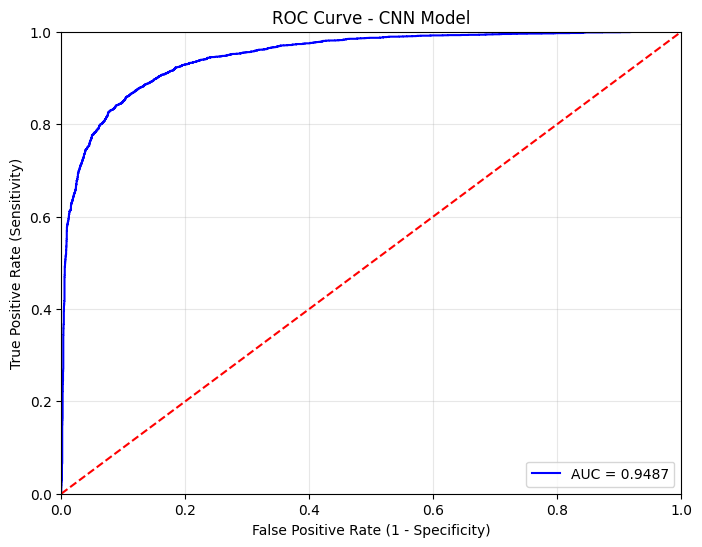

In [36]:
# Assuming you have already defined and trained the CNN model as 'model' 
# (from Step 1 and Step 3 of the CNN instructions)

# Create lists to hold data for the whole validation set
all_targets = []
all_probs = [] 

model.eval() # <--- This 'model' is now your CNN
with torch.no_grad():
    for inputs, targets, lengths in val_loader:
        # 1. Forward pass (The CNN handles the dimension swapping internally)
        logits = model(inputs)
        
        # 2. Create mask to ignore padding (Same as LSTM)
        mask = torch.arange(inputs.size(1), device=device)[None, :] < lengths[:, None]
        
        # 3. Get Probabilities (Same as LSTM)
        probs = torch.sigmoid(logits)
        
        # 4. Select only real data (Same as LSTM)
        valid_probs = torch.masked_select(probs, mask).cpu().numpy()
        valid_targets = torch.masked_select(targets, mask).cpu().numpy()
        
        all_probs.extend(valid_probs)
        all_targets.extend(valid_targets)

print("CNN Data collected for ROC Curve.")

# --- Plotting Section (Identical Logic) ---
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(all_targets, all_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.title('ROC Curve - CNN Model') # <--- Changed Title
plt.plot(fpr, tpr, 'b', label = f'AUC = {roc_auc:.4f}') 
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--') 
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate (Sensitivity)')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.grid(True, alpha=0.3)
plt.show()

In [37]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
import numpy as np

# 1. Define the LSTM Model
class FoGLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=1):
        super(FoGLSTM, self).__init__()
        
        # LSTM Layer
        # input_dim: 14 (features)
        # hidden_dim: 64 (memory size)
        self.lstm = nn.LSTM(input_size=input_dim, 
                            hidden_size=hidden_dim, 
                            num_layers=num_layers, 
                            batch_first=True) # Expects (Batch, Time, Features)
        
        # Classifier Layer
        # Takes the memory (hidden state) and decides 0 or 1
        self.classifier = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        # x shape: (Batch, Time, Features)
        
        # LSTM returns: output, (hidden_state, cell_state)
        # We only care about 'output' which contains features for every timestep
        lstm_out, _ = self.lstm(x) 
        
        # lstm_out shape: (Batch, Time, 64)
        
        # Pass every timestep through the classifier to get probability
        logits = self.classifier(lstm_out)
        
        # logits shape: (Batch, Time, 1) -> Squeeze to (Batch, Time)
        return logits.squeeze(2)

print("LSTM Model defined successfully!")

LSTM Model defined successfully!


In [38]:
# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Split Data (using Sklearn as requested)
indices = np.arange(len(X_seqs))
train_idx, val_idx = train_test_split(indices, test_size=0.2, random_state=42, shuffle=True)

# Helper to pad sequences (make them all same length)
def collate_fn(batch):
    xs = [item[0] for item in batch]
    ys = [item[1] for item in batch]
    lengths = torch.tensor([len(x) for x in xs])
    
    # Pad inputs and targets
    xs_padded = pad_sequence([torch.tensor(x).float() for x in xs], batch_first=True)
    ys_padded = pad_sequence([torch.tensor(y).float() for y in ys], batch_first=True)
    
    return xs_padded.to(device), ys_padded.to(device), lengths.to(device)

class SimpleDataset(torch.utils.data.Dataset):
    def __init__(self, x_data, y_data, indices):
        self.x = [x_data[i] for i in indices]
        self.y = [y_data[i] for i in indices]
    def __len__(self): return len(self.x)
    def __getitem__(self, i): return self.x[i], self.y[i]

train_loader = DataLoader(SimpleDataset(X_seqs, y_seqs, train_idx), batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(SimpleDataset(X_seqs, y_seqs, val_idx), batch_size=32, shuffle=False, collate_fn=collate_fn)

In [39]:
import copy  # <--- Essential for saving the best model

# Initialize Model
input_features = X_seqs[0].shape[1]
model = FoGLSTM(input_dim=input_features, hidden_dim=64).to(device)

# Loss and Optimizer
criterion = nn.BCEWithLogitsLoss(reduction='none') 
optimizer = optim.Adam(model.parameters(), lr=0.005)

# --- EARLY STOPPING SETUP ---
num_epochs = 20          # <--- Increased to 20
patience = 5             # <--- Stop if no improvement for 5 epochs
best_val_loss = float('inf')
counter = 0
best_model_wts = None
# ----------------------------

print(f"{'Epoch':<8} {'Train Loss':<12} {'Val Loss':<12} {'Val Acc':<12}")
print("-" * 65)

for epoch in range(num_epochs):
    
    # --- Training Phase ---
    model.train()
    train_losses = []

    for inputs, targets, lengths in train_loader:
        optimizer.zero_grad()
        
        logits = model(inputs)
        
        # Create Mask
        mask = torch.arange(inputs.size(1), device=device)[None, :] < lengths[:, None]
        
        loss = criterion(logits, targets)
        masked_loss = (loss * mask).sum() / mask.sum()
        
        masked_loss.backward()
        optimizer.step()
        train_losses.append(masked_loss.item())

    # --- Validation Phase ---
    model.eval()
    val_losses = []
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for inputs, targets, lengths in val_loader:
            logits = model(inputs)
            mask = torch.arange(inputs.size(1), device=device)[None, :] < lengths[:, None]
            
            loss = criterion(logits, targets)
            masked_loss = (loss * mask).sum() / mask.sum()
            val_losses.append(masked_loss.item())
            
            # Predictions
            probs = torch.sigmoid(logits)
            preds = (probs > 0.5).float()
            
            # Filter out padding for metrics
            valid_preds = torch.masked_select(preds, mask).cpu().numpy()
            valid_targets = torch.masked_select(targets, mask).cpu().numpy()
            
            all_preds.extend(valid_preds)
            all_targets.extend(valid_targets)

    # --- Calculate Metrics ---
    avg_train_loss = np.mean(train_losses)
    avg_val_loss = np.mean(val_losses)
    
    val_accuracy = accuracy_score(all_targets, all_preds)
    val_precision = precision_score(all_targets, all_preds, zero_division=0)
    val_recall = recall_score(all_targets, all_preds, zero_division=0)

    print(f"Epoch {epoch:<3}: "
          f"Train Loss: {avg_train_loss:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} | "
          f"Val Acc: {val_accuracy:.4f} | "
          f"Val Prec: {val_precision:.4f} | "
          f"Val Rec: {val_recall:.4f}")

    # --- EARLY STOPPING LOGIC ---
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_wts = copy.deepcopy(model.state_dict()) # Save best model
        counter = 0
        print(f"    --> New best model saved! (Val Loss: {avg_val_loss:.4f})")
    else:
        counter += 1
        print(f"    --> No improvement. Patience: {counter}/{patience}")
        if counter >= patience:
            print("Early stopping triggered!")
            break

# --- Final: Load the best weights found ---
if best_model_wts:
    model.load_state_dict(best_model_wts)
    print(f"\nTraining finished. Loaded best model with Val Loss: {best_val_loss:.4f}")

Epoch    Train Loss   Val Loss     Val Acc     
-----------------------------------------------------------------
Epoch 0  : Train Loss: 0.4848 | Val Loss: 0.4580 | Val Acc: 0.8287 | Val Prec: 0.8798 | Val Rec: 0.6790
    --> New best model saved! (Val Loss: 0.4580)
Epoch 1  : Train Loss: 0.4171 | Val Loss: 0.4188 | Val Acc: 0.8507 | Val Prec: 0.8791 | Val Rec: 0.7415
    --> New best model saved! (Val Loss: 0.4188)
Epoch 2  : Train Loss: 0.3853 | Val Loss: 0.4171 | Val Acc: 0.8438 | Val Prec: 0.9445 | Val Rec: 0.6616
    --> New best model saved! (Val Loss: 0.4171)
Epoch 3  : Train Loss: 0.3824 | Val Loss: 0.4234 | Val Acc: 0.8363 | Val Prec: 0.9511 | Val Rec: 0.6374
    --> No improvement. Patience: 1/5
Epoch 4  : Train Loss: 0.3489 | Val Loss: 0.3668 | Val Acc: 0.8878 | Val Prec: 0.9430 | Val Rec: 0.7758
    --> New best model saved! (Val Loss: 0.3668)
Epoch 5  : Train Loss: 0.3666 | Val Loss: 0.4122 | Val Acc: 0.8485 | Val Prec: 0.9320 | Val Rec: 0.6839
    --> No improvement. Pati

In [40]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

In [41]:
# Create lists to hold data for the whole validation set
all_targets = []
all_probs = [] # <--- CHANGED: We need probabilities, not just 0/1 predictions

model.eval()
with torch.no_grad():
    for inputs, targets, lengths in val_loader:
        logits = model(inputs)
        
        # Create mask to ignore padding
        mask = torch.arange(inputs.size(1), device=device)[None, :] < lengths[:, None]
        
        # Get Probabilities (0.0 to 1.0)
        probs = torch.sigmoid(logits)
        
        # Select only real data (remove padding)
        valid_probs = torch.masked_select(probs, mask).cpu().numpy()
        valid_targets = torch.masked_select(targets, mask).cpu().numpy()
        
        all_probs.extend(valid_probs)
        all_targets.extend(valid_targets)

print("Data collected for ROC Curve.")

Data collected for ROC Curve.


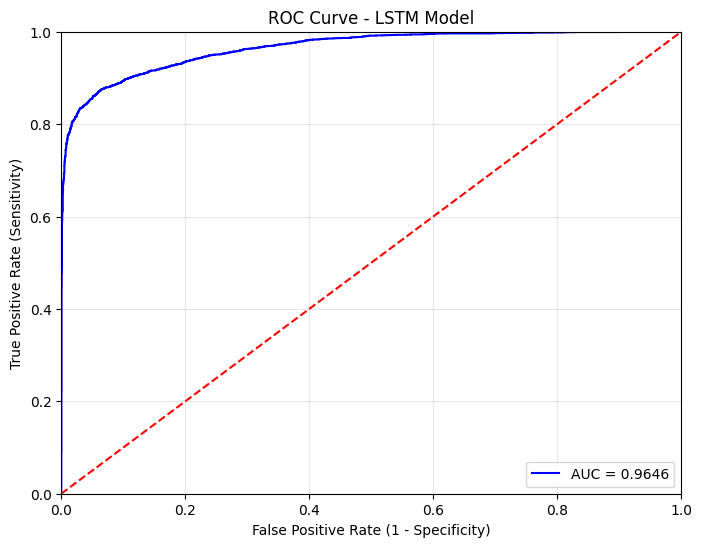

In [42]:
# 1. Calculate the false positive rate (fpr) and true positive rate (tpr)
fpr, tpr, thresholds = roc_curve(all_targets, all_probs)

# 2. Calculate the Area Under Curve (AUC)
roc_auc = auc(fpr, tpr)

# 3. Plotting
plt.figure(figsize=(8, 6))
plt.title('ROC Curve - LSTM Model')
plt.plot(fpr, tpr, 'b', label = f'AUC = {roc_auc:.4f}') # 'b' for blue line
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--') # Red dashed line: Random guessing (baseline)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate (Sensitivity)')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.grid(True, alpha=0.3)
plt.show()